# TMDB Box Office Prediction

Этот набор данных был собран из TMDB. Информация о фильме, титры и ключевые слова были собраны из открытого API TMDB.

Датасет содержит такие колонки, как:

1. id (int64) - уникальный идентификатор фильма.

2. belongs_to_collection (json) - коллекция, к которой относится фильм.

    Json содержит поля:
    - name - название коллекции,
    - poster_path - путь к фото постера коллекции,
    - backdrop_path - изображение, извлеченное из фильма.

3. budget (int64) - бюджет фильма в долларах.

4. genres (json array) - жанры, к которому относится фильм.

    Каждый Json массива имеет поля:
    - id - уникальный идентификатор жанра,
    - name - название жанра.

5. homepage (url) - ссылка на домашнюю страницу фильма.

6. imdb_id ("tt" + id) - уникальный идентификатор фильма на TMDB.

7. original_language (string, len = 2) - оригинальный язык фильма.

8. original_title (string) - название фильма на оригинальном языке.

9. overview (string) - описание фильма.

10. popularity (float64) - популярность фильма (0 - 54.75).

11. poster_path (url) - путь к фото постера фильма.

12. production_companies (json array) - компании, которые работали над фильмом.

    Каждый Json массива имеет поля:
    - id - уникальный идентификатор компании,
    - name - название комании.

13. production_countries (json array) - страны производства (относится к production_companies).

    Каждый Json массива имеет поля:
    - iso_3166_1 - код страны,
    - name - полное название страны.

14. release_date (date) - дата выхода фильма (месяц/день/год).

15. runtime (float64) - продолжительность фильма (в минутах).

16. spoken_languages (json array) - языки, присутствующие в фильме.

    Каждый Json массива имеет поля:
    - iso_3166_1 - код страны,
    - name - полное название страны.

17. status (string) - статус фильма (имеет одно значение Released, и, следовательно, не имеет смысла).

18. tagline (string) - подзаголовок фильма (краткое описание, слоган).

19. title (string) - название фильма.
20. Keywords (json array) - ключевые слова.

    Каждый Json массива имеет поля:
    - id - уникальный идентификатор ключевого слова,
    - name - название ключевого слова.

21. cast (array json) - актёрский состав.

    Каждый Json массива имеет поля:
    - character - имя персонажа,
    - credit_id: уникальный идентификатор, по котоому можно получить список титров, где учавствовал данный актёр,
    - gender: - пол
    - id: уникальный идентификатор актёра
    - name: - полное имя актёра,
    - order: - номер порядка,
    - profile_path - ссылка на профиль в TMDB.

22. crew (array json) - съёмочная группа.

    Каждый Json массива имеет поля:
    - credit_id - уникальный идентификатор, по котоому можно получить список титров, где учавствовал данный участник группы,
    - department - отдел,
    - gender - пол,
    - id - уникальный идентификатор участника группы,
    - job - ответственность в производстве фильма,
    - name - полное имя участника группы,
    - profile_path - ссылка на профиль в TMDB.

23. revenue (int64) - сборы фильма.

Так как тестовые данные не содержат колонки со сборами фильма, а нашей задачей является оценка точности полученной модели, мы использовали тренировочные данные, которые впоследствии разделили на тренировочную и тестовую выборки.

## Установка и импорт пакетов

In [ ]:
%pip install pandas wordcloud scikit-learn numpy seaborn

In [348]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import json
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import warnings

## Ignore warnings

In [349]:
warnings.filterwarnings('ignore')

## Функции для обработки данных

In [350]:
# Парсит JSON, убирает дубликаты, возвращает остортированный список по количеству дубликатов
# Нужно для анализа популярности значений в JSON'e
def get_info_table_json(column, id):
    df_item = pd.json_normalize(column.explode())
    df_item = df_item.dropna()
    df_item['duplicate_count'] = df_item.groupby(id)[id].transform('count')
    df_item = df_item.drop_duplicates(subset=id)
    df_item.sort_values(by='duplicate_count',ascending=False, inplace=True)
    return df_item

# Преобразует JSON в строку значений через запятую
def get_items_from_json(item_name, column_name):
    col = data[column_name].apply(lambda x: ', '.join([item[item_name] for item in x])if x != [] else '')
    return col


# Данные

In [351]:
data = pd.read_csv('data/train.csv')
data.head(5)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   
3   4                                                NaN   1200000   
4   5                                                NaN         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   
2  Under the direction of a ruthless instructor, ...   64.299990   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936   
4  Marine Boy is the story of a former national s...    1.148070   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   
2  /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg   
3  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   
2  [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3                                                NaN   
4                                                NaN   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...      2/20/15     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...       8/6/04    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...     10/10/14    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]       3/9/12    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]       2/5/09    118.0   

                                    spoken_languages    status  \
0           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
3  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
4           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name':

## Рассмотри подробнее колонки Json'ов и изменим их

In [352]:
pd.set_option('display.max_colwidth', 400)
display(data.select_dtypes(include=['object']).drop(['imdb_id', 'homepage', 'original_language', 'original_title',
                                             'overview', 'poster_path', 'release_date', 'status', 'tagline', 'title'], axis=1).head(1))

pd.reset_option('display.max_colwidth')

belongs_to_collection  \
0  [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]   

                           genres  \
0  [{'id': 35, 'name': 'Comedy'}]   

                                                                                                                 production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]   

                                         production_countries  \
0  [{'iso_3166_1': 'US', 'name': 'United States of America'}]   

                           spoken_languages  \
0  [{'iso_639_1': 'en', 'name': 'English'}]   

                                                                                                                                                  Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]   

                                                                                                                                                                                                                                                                                                                                                                                                              cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id':...   

                                                                                                                                                                                                                                                                                                                                                                                                              crew  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3...

### Колонка belongs_to_collection

Смотрим, какие данные имеют колонки

In [353]:
# Заменяем пустые значения пустыми массивами
data['belongs_to_collection'] = data['belongs_to_collection'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["belongs_to_collection"][i]}')

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 []
3 []
4 []


In [354]:
# Смотрим, есть ли фильмы, которые относятся к нескольким коллекциям
data['belongs_to_collection'].apply(lambda x: len(x) if x != [] else 0).value_counts()

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64

У всех фильмов либо есть одна коллекция, либо нет вообще, поэтому оставим только факт её наличия и имя

In [355]:
# Название коллекции
data['collection_name'] = data['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != [] else 0)
# Факт наличия коллекции
data['has_collection'] = data['belongs_to_collection'].apply(lambda x: len(x) if x != [] else 0)

### Колонка genres

Смотрим содержание колонок, а также на пренадлежность фильмов к нескольким жанрам

In [356]:
# Теперь проверим фильмы на пренадлежность к нескольким жанрам
# Здесь мы парсим один JSON, содержащий жанры, в массив JSON'ов жанров 
data['genres'] = data['genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["genres"][i]}')

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


Как мы видим, один фильм может иметь несколько жанров.

In [357]:
# Посмотрим на популярность каждого жанра
info_genres = get_info_table_json(data['genres'], 'id')
print("Всего", len(info_genres), "жанров")
display(info_genres)

Всего 20 жанров


id             name  duplicate_count
2        18.0            Drama             1531
0        35.0           Comedy             1028
6        53.0         Thriller              789
8        28.0           Action              741
4     10749.0          Romance              571
27       80.0            Crime              469
11       12.0        Adventure              439
13       27.0           Horror              301
30      878.0  Science Fiction              290
3     10751.0           Family              260
77       14.0          Fantasy              232
31     9648.0          Mystery              225
10       16.0        Animation              141
220      36.0          History              132
95    10752.0              War              100
18    10402.0            Music              100
15       99.0      Documentary               87
96       37.0          Western               43
53    10769.0          Foreign               31
4228  10770.0         TV Movie                1

Всего жанров 20, поэтому их можно оставить, будем создавать новые колонки, соответсвующие определённым жанрам, указывай факт принадлежности его к фильму (как в One Hot Encoding)

In [358]:
# Получим список названий жанров к каждому фильму
data['genres_names'] = get_items_from_json('name', 'genres')
# Преобразуем данные и добавим их в таблицу
new_columns = pd.DataFrame(index=data.index)
for g in info_genres['name']:
    new_columns['genre_' + g] = data['genres_names'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов фильма от жанров

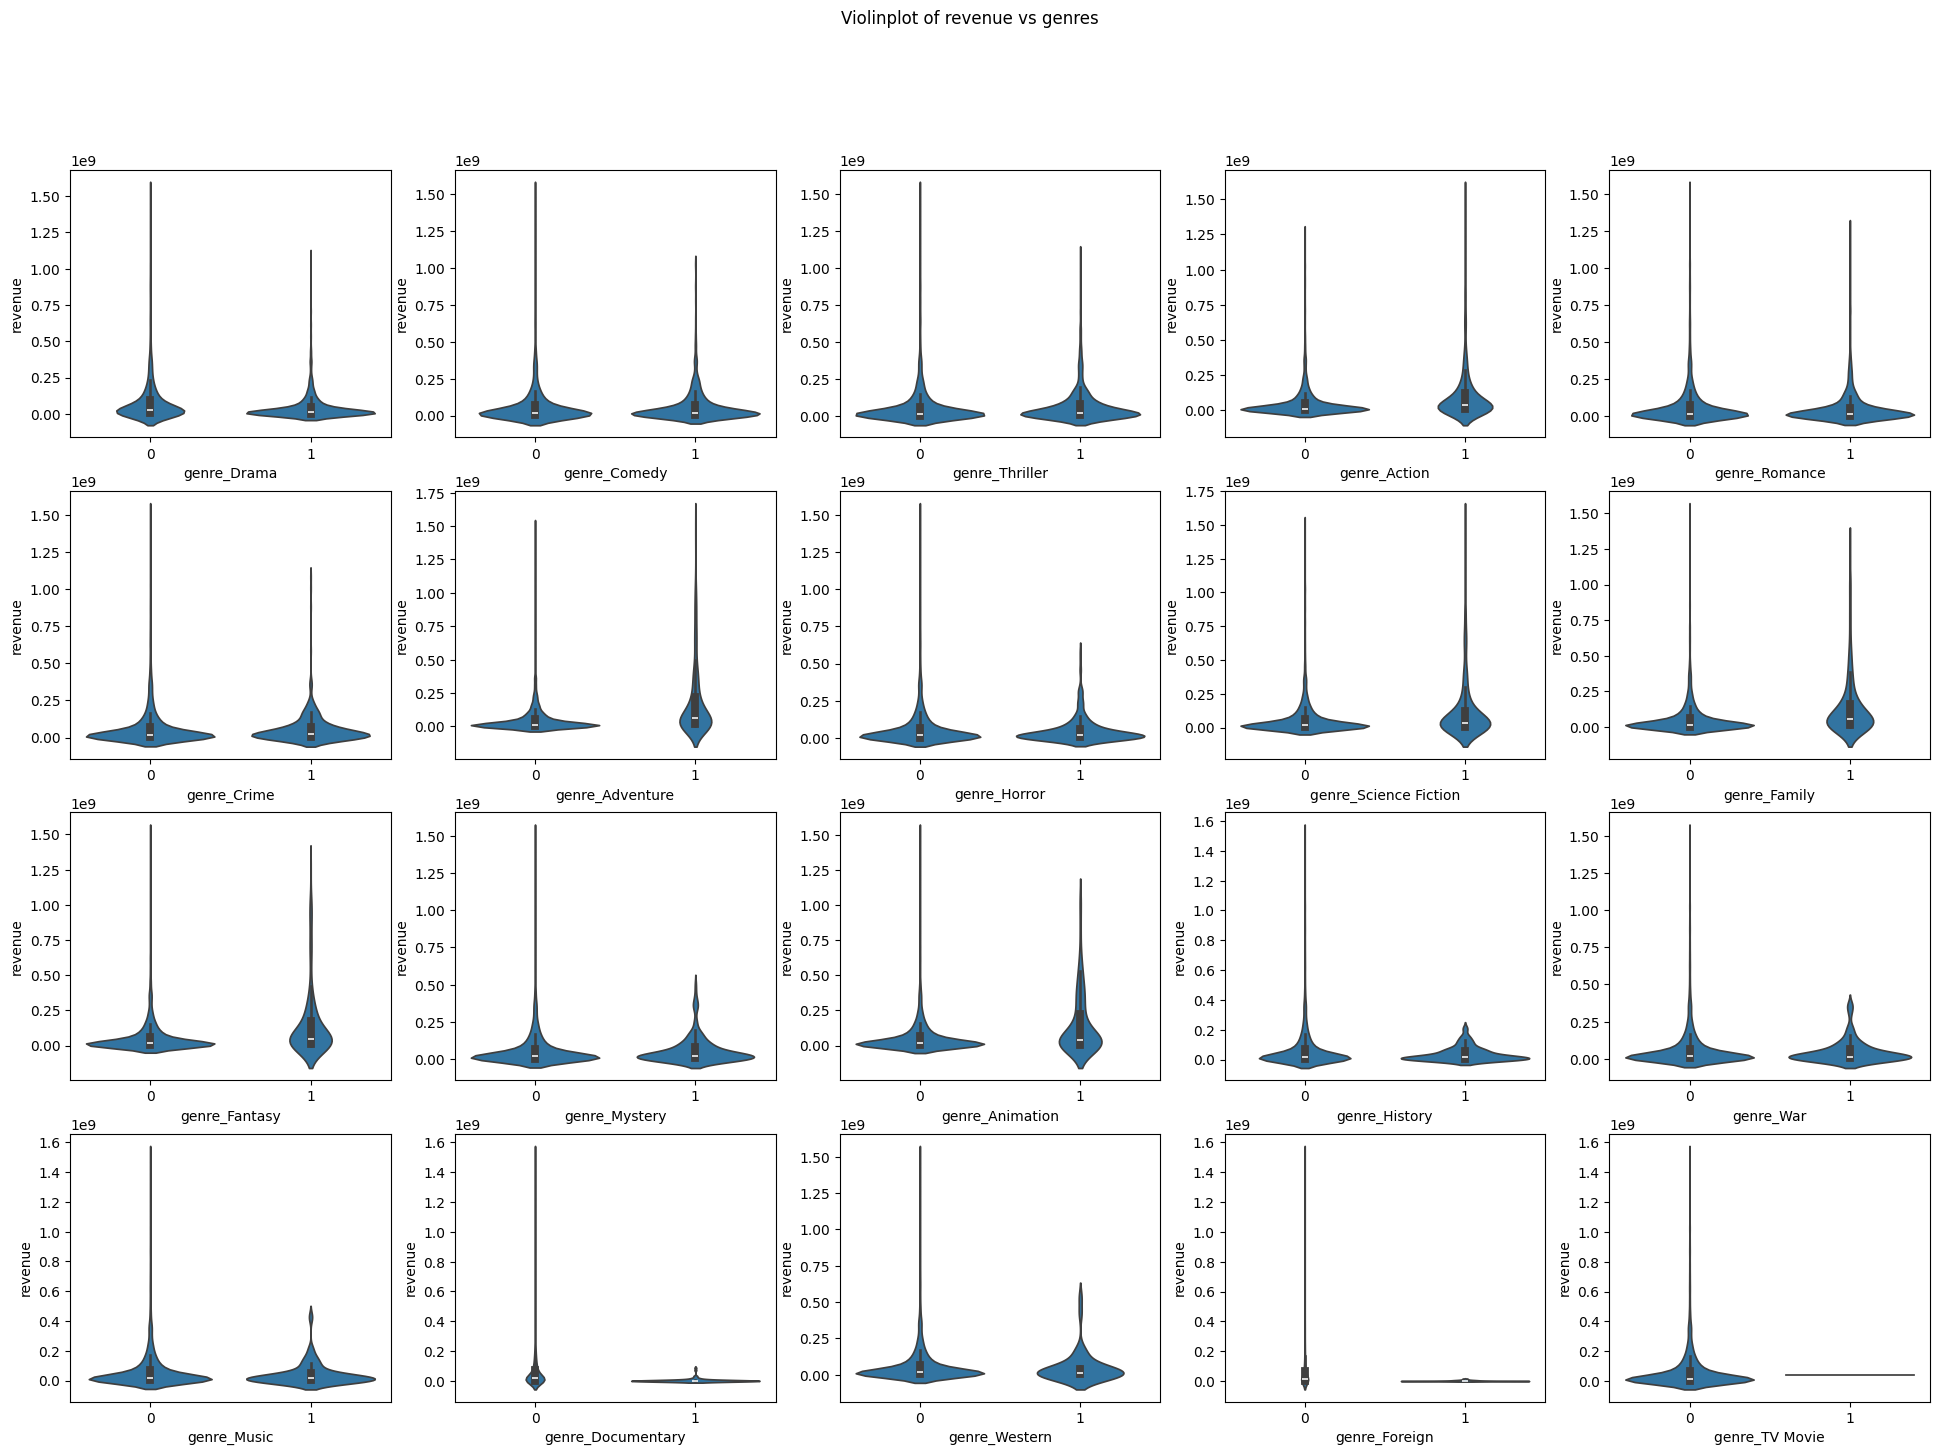

In [359]:
f, axes = plt.subplots(4, 5, figsize=(24, 16))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in data.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5])

Графики (слева направо и сверху вниз) расположены в порядке уменьшения количества фильмов, имеющих тот или иной жанр. На графиках можно увидеть распределение количества фильмов по сборам в зависимости от присутствия или отсутствия жанра.

### Колонка production_companies

Смотрим, что содержится в колонках и может ли фильм иметь несколько производственных компаний

In [360]:
data['production_companies'] = data['production_companies'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["production_companies"][i]}')

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 []
4 []


Посмотрим, какие компании принимали участие в большем количестве фильмов

In [361]:
info_production_companies = get_info_table_json(data['production_companies'], 'id')
info_production_companies

name       id  duplicate_count
128                             Warner Bros.   6194.0              202
68                        Universal Pictures     33.0              188
0                         Paramount Pictures      4.0              161
18    Twentieth Century Fox Film Corporation    306.0              138
157                        Columbia Pictures      5.0               91
...                                      ...      ...              ...
2966                            Zwart Arbeid  44997.0                1
53               Sea Side Films Florida Inc.  95342.0                1
2974                             Archipel 35   2695.0                1
2977                                Eyeworks   6461.0                1
8250                 Quick Six Entertainment  24561.0                1

[3712 rows x 3 columns]

Здесь целых 3712 компании, поэтому оставим самые популярные из них и применим к ним one hot encoding

In [362]:
data['production_companies_names'] = get_items_from_json('name', 'production_companies')
new_columns = pd.DataFrame(index=data.index)
for g in info_production_companies['name'][:30]:
    new_columns['production_company_' + g] = data['production_companies_names'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов фильма от компании

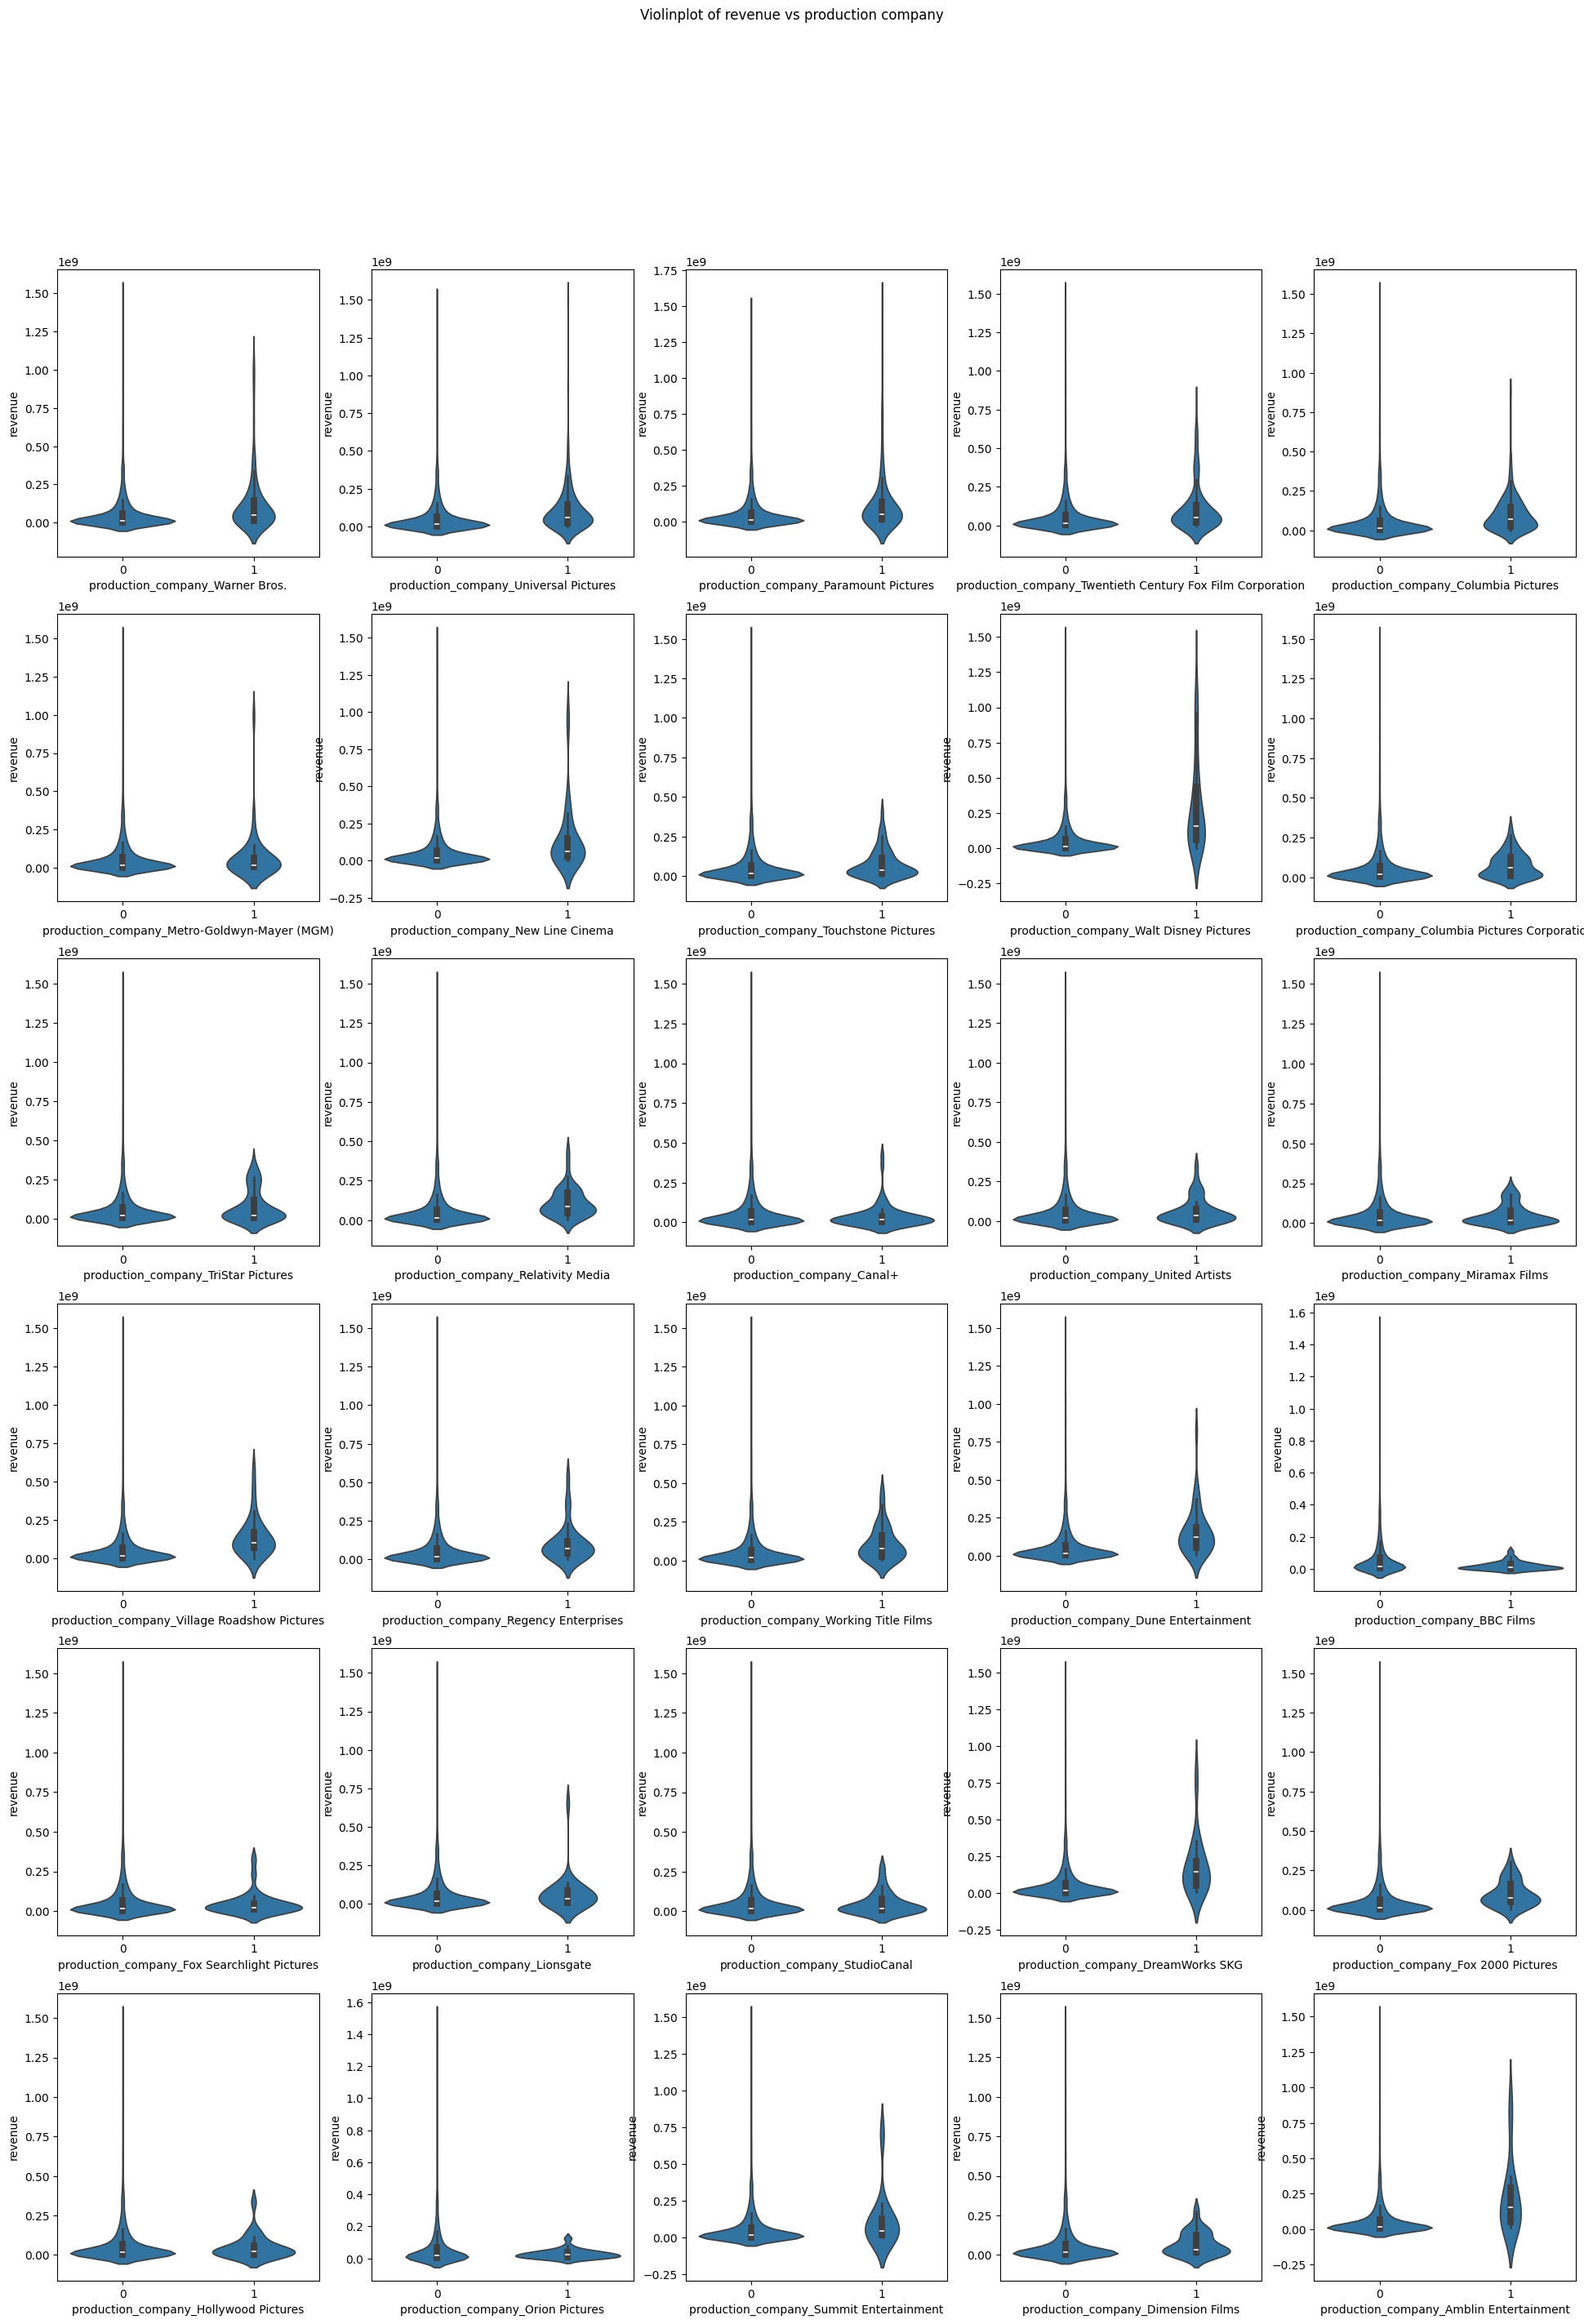

In [363]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in data.columns if 'production_company_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

Графики (слева направо и сверху вниз) расположены в порядке уменьшения количества фильмов, в которых учавствовали те или иные компании. На графиках можно увидеть распределение количества фильмов по сборам в зависимости от присутствия или отсутствия определённой компании.

### Колонка production_countries

Посмотрим, как выглядят данные

In [364]:
data['production_countries'] = data['production_countries'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["production_countries"][i]}')

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


Посмотрим на уникальные значения стран

In [365]:
info_production_countries = get_info_table_json(data['production_countries'], 'iso_3166_1')
info_production_countries

iso_3166_1                      name  duplicate_count
0            US  United States of America             2282
18           GB            United Kingdom              380
22           FR                    France              222
20           DE                   Germany              167
7            CA                    Canada              120
...         ...                       ...              ...
1502         PT                  Portugal                1
1343         ET                  Ethiopia                1
1310         DZ                   Algeria                1
1032         NA                   Namibia                1
490          MN                  Mongolia                1

[74 rows x 3 columns]

Так как общее количество стран велико, сделаем то же самое, что и с production_companies

In [366]:
data['production_countries_id'] = get_items_from_json('iso_3166_1', 'production_countries')
data['production_countries_id']
new_columns = pd.DataFrame(index=data.index)
for g in info_production_countries['iso_3166_1'][:30]:
    new_columns['production_country_' + g] = data['production_countries_id'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов от стран производства

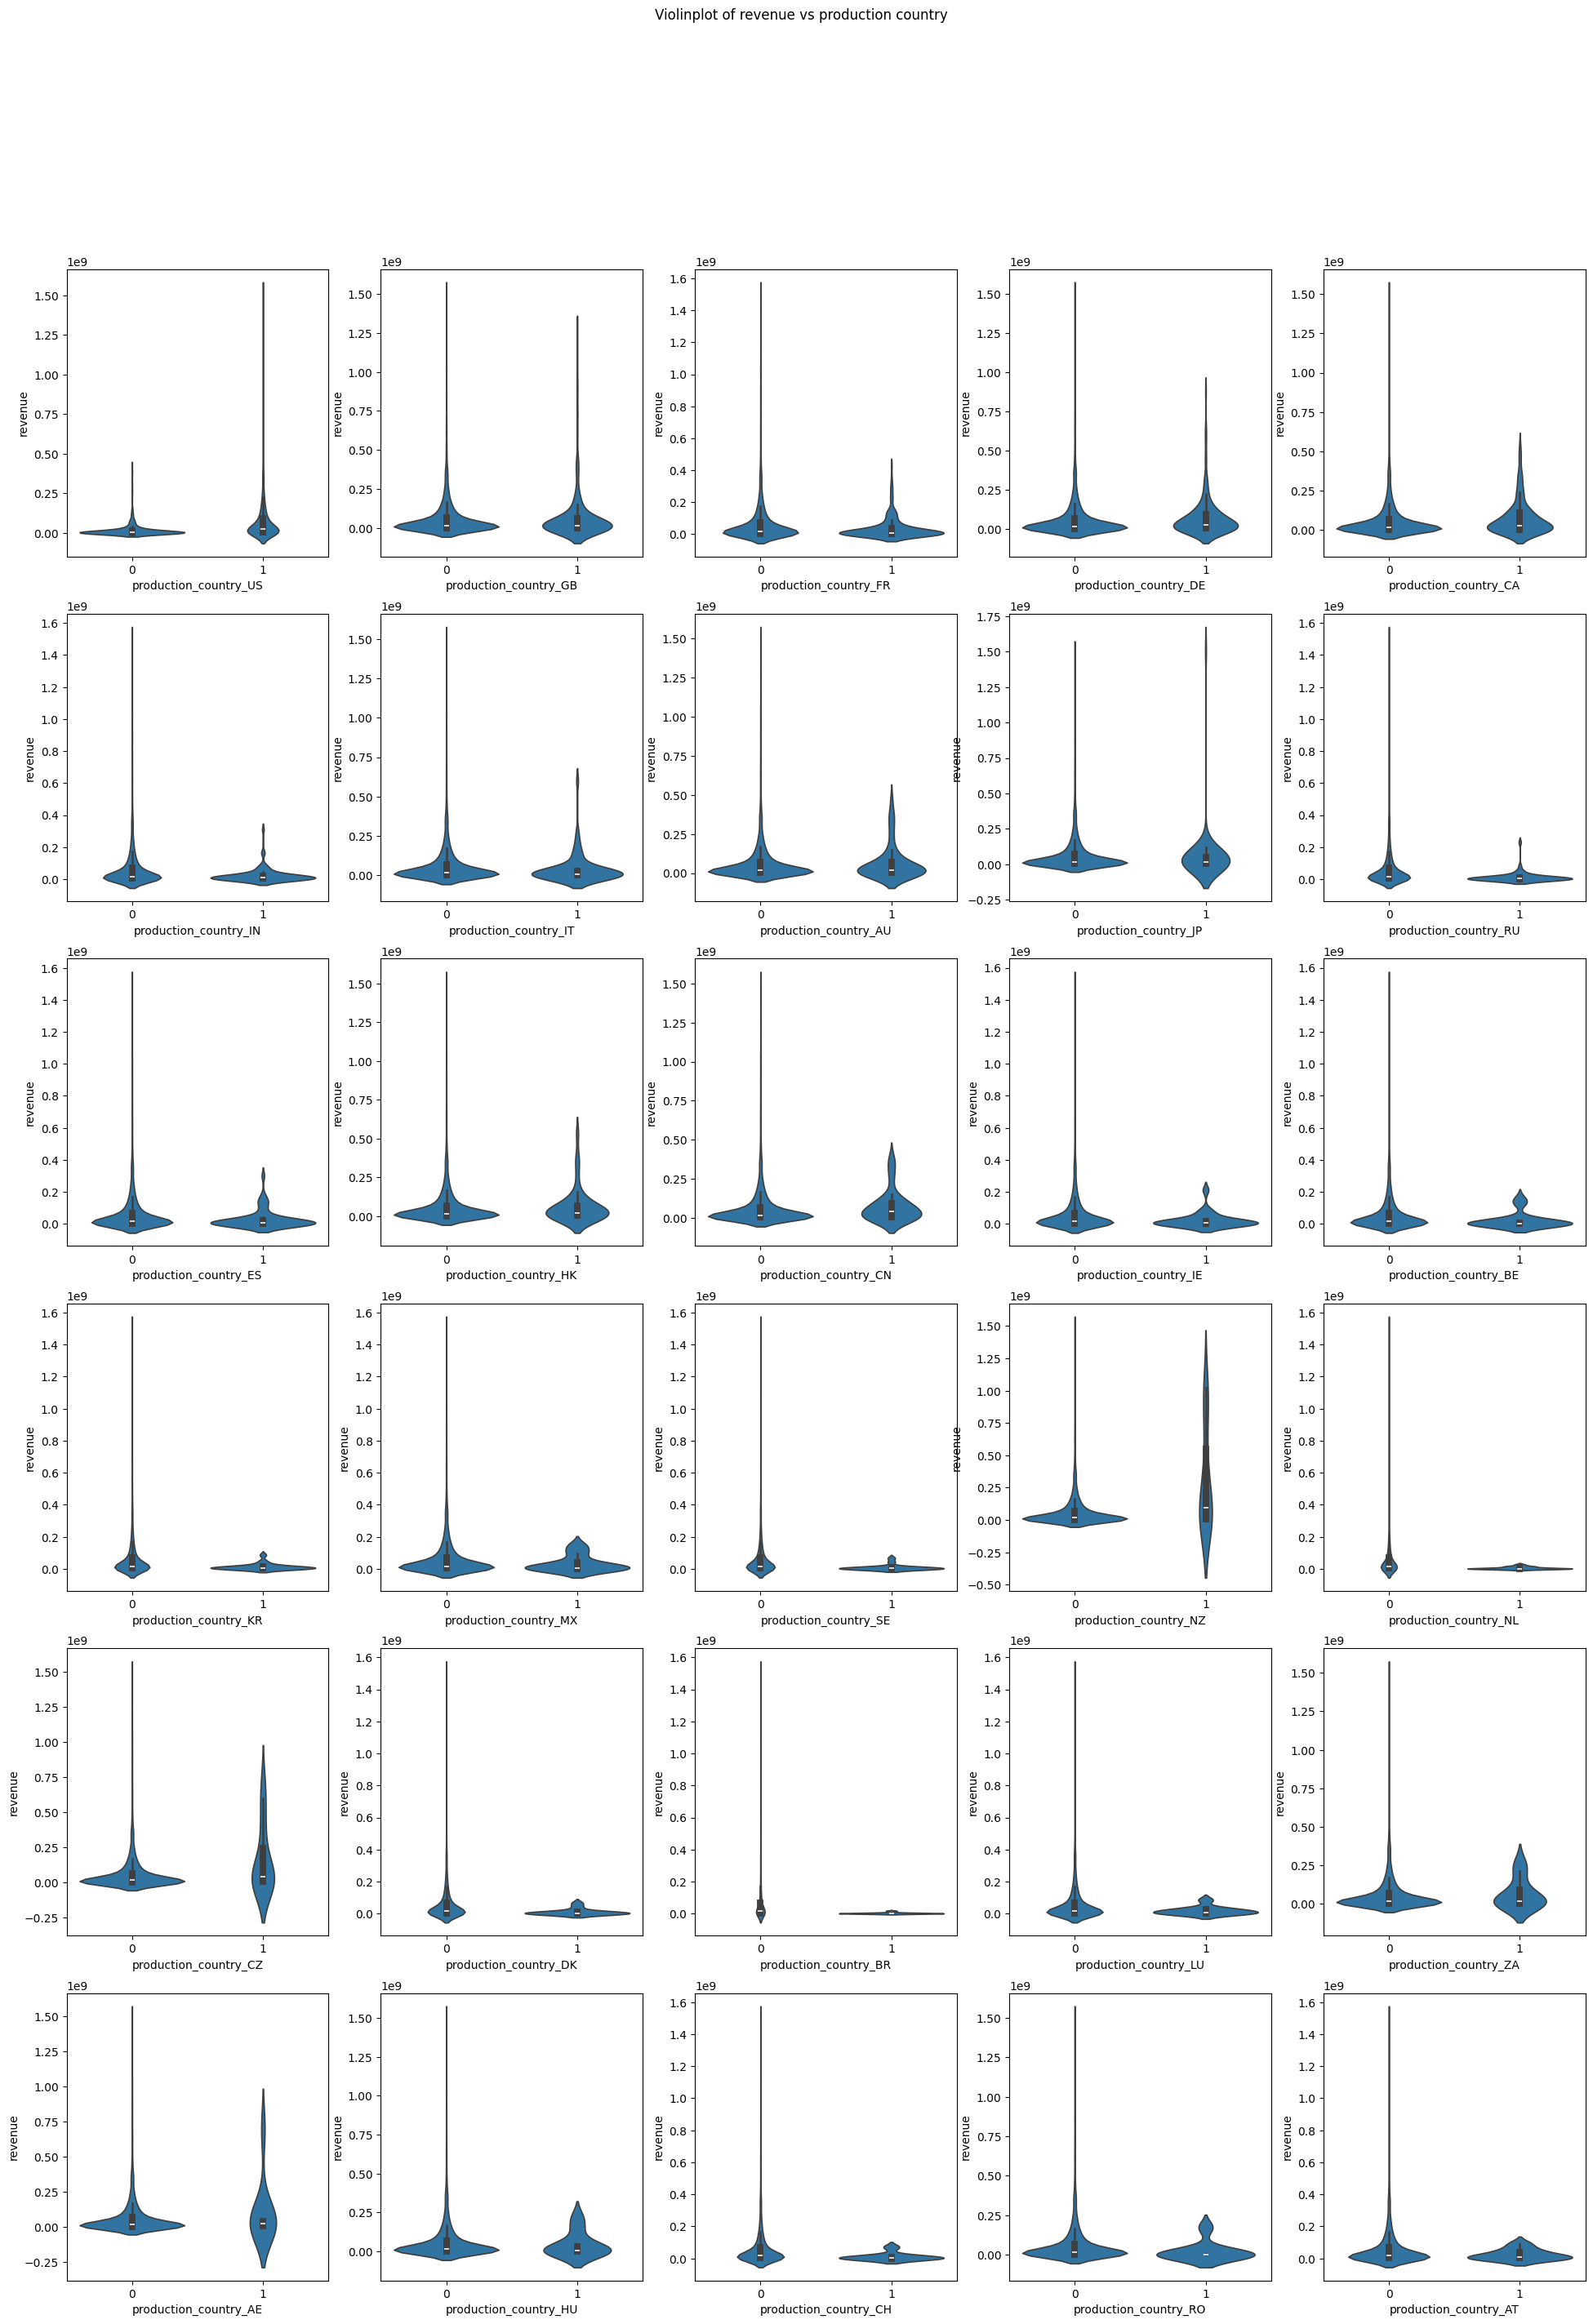

In [367]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in data.columns if 'production_country_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

Здесь можно увидеть, что у некоторых стран были отрицательные значения сборов фильма, что, возможно, говорит о качестве фильмов, снятых производственными компаниями в этих странах.

### Колонка spoken_languages

Здесь такая же ситуация, как и у прошлых двух признаков, поэтому проделаем все те же действия

In [368]:
data['spoken_languages'] = data['spoken_languages'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["spoken_languages"][i]}')

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [369]:
info_spoken_languages = get_info_table_json(data['spoken_languages'], 'iso_639_1')
data['spoken_languages_id'] = get_items_from_json('iso_639_1', 'spoken_languages')
new_columns = pd.DataFrame(index=data.index)
for g in info_spoken_languages['iso_639_1'][:30]:
    new_columns['spoken_language_' + g] = data['spoken_languages_id'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов от языков, присутствующих в фильме

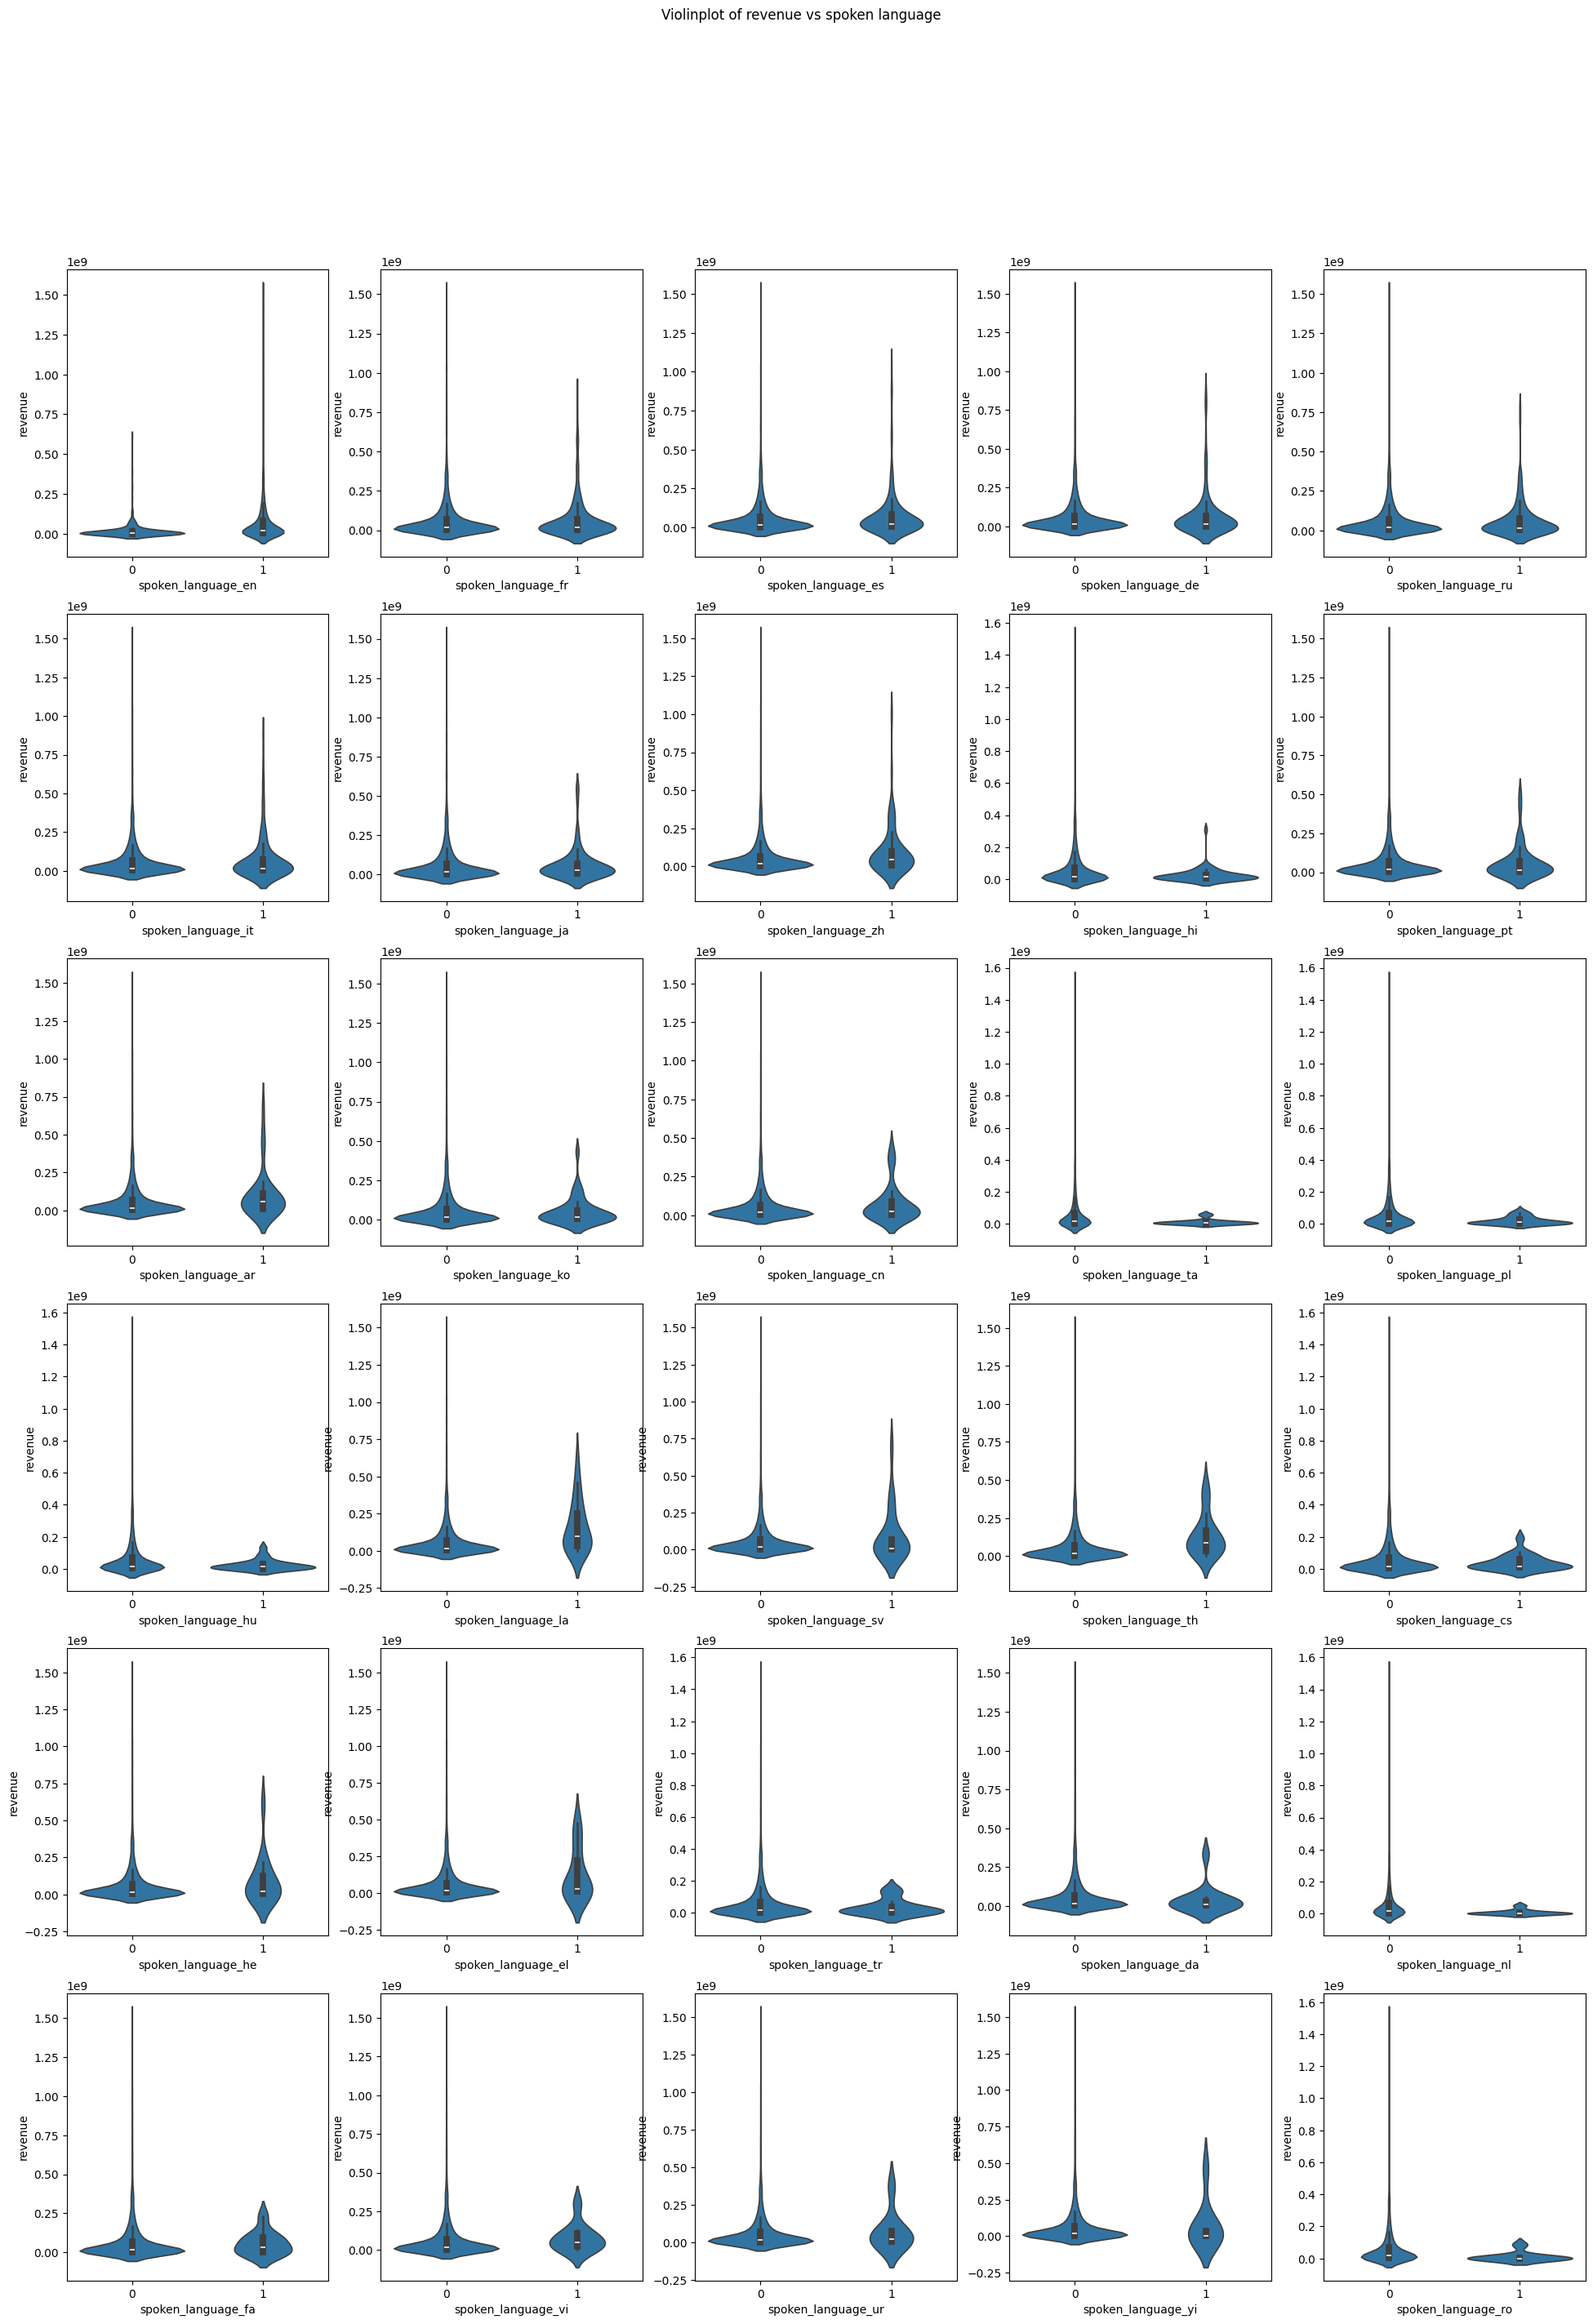

In [370]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs spoken language')
for i, e in enumerate([col for col in data.columns if 'spoken_language_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

Видно, что присуствие или отстуствие того или иного языка, так же влияет на сборы фильма (иногда негативно)

### Колонка Keywords

Иследуем данные на содержимое и "популярность"

In [371]:
data['Keywords'] = data['Keywords'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["Keywords"][i]}')

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [372]:
info_Keywords = get_info_table_json(data['Keywords'], 'id')
print("Кол-во ключевых слов:", len(info_Keywords))
display(info_Keywords.head(30))

Кол-во ключевых слов: 7400


id                     name  duplicate_count
36    187056.0           woman director              175
156    10183.0         independent film              155
3     179431.0     duringcreditsstinger              134
100     9826.0                   murder              123
259      818.0           based on novel              111
13     14819.0                 violence               87
440     6075.0                    sport               82
109     5565.0                biography               77
1281  179430.0      aftercreditsstinger               75
553     9748.0                  revenge               73
99      4565.0                 dystopia               73
172     6054.0               friendship               72
202      572.0                      sex               71
168     9937.0                 suspense               67
1       9663.0                   sequel               66
405     6149.0                   police               64
212     9673.0                     love               64
425    13130.0                 teenager               61
74      2483.0                   nudity               57
66       293.0            female nudity               53
751    14964.0                     drug               52
232      378.0                   prison               50
364     6270.0              high school               49
363     4344.0                  musical               49
251    12670.0              los angeles               48
166      242.0                 new york               47
414    18035.0                   family               45
952      494.0  father son relationship               44
1052    5340.0            investigation               41
120     1930.0               kidnapping               41

Слов явно многовато, применяем все те же действия, что и к предыдущим колонкам

In [373]:
data['Keywords_name'] = get_items_from_json('name', 'Keywords')
new_columns = pd.DataFrame(index=data.index)
for g in info_Keywords['name'][:30]:
    new_columns['Keyword_' + g] = data['Keywords_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов фильма от ключевых слов

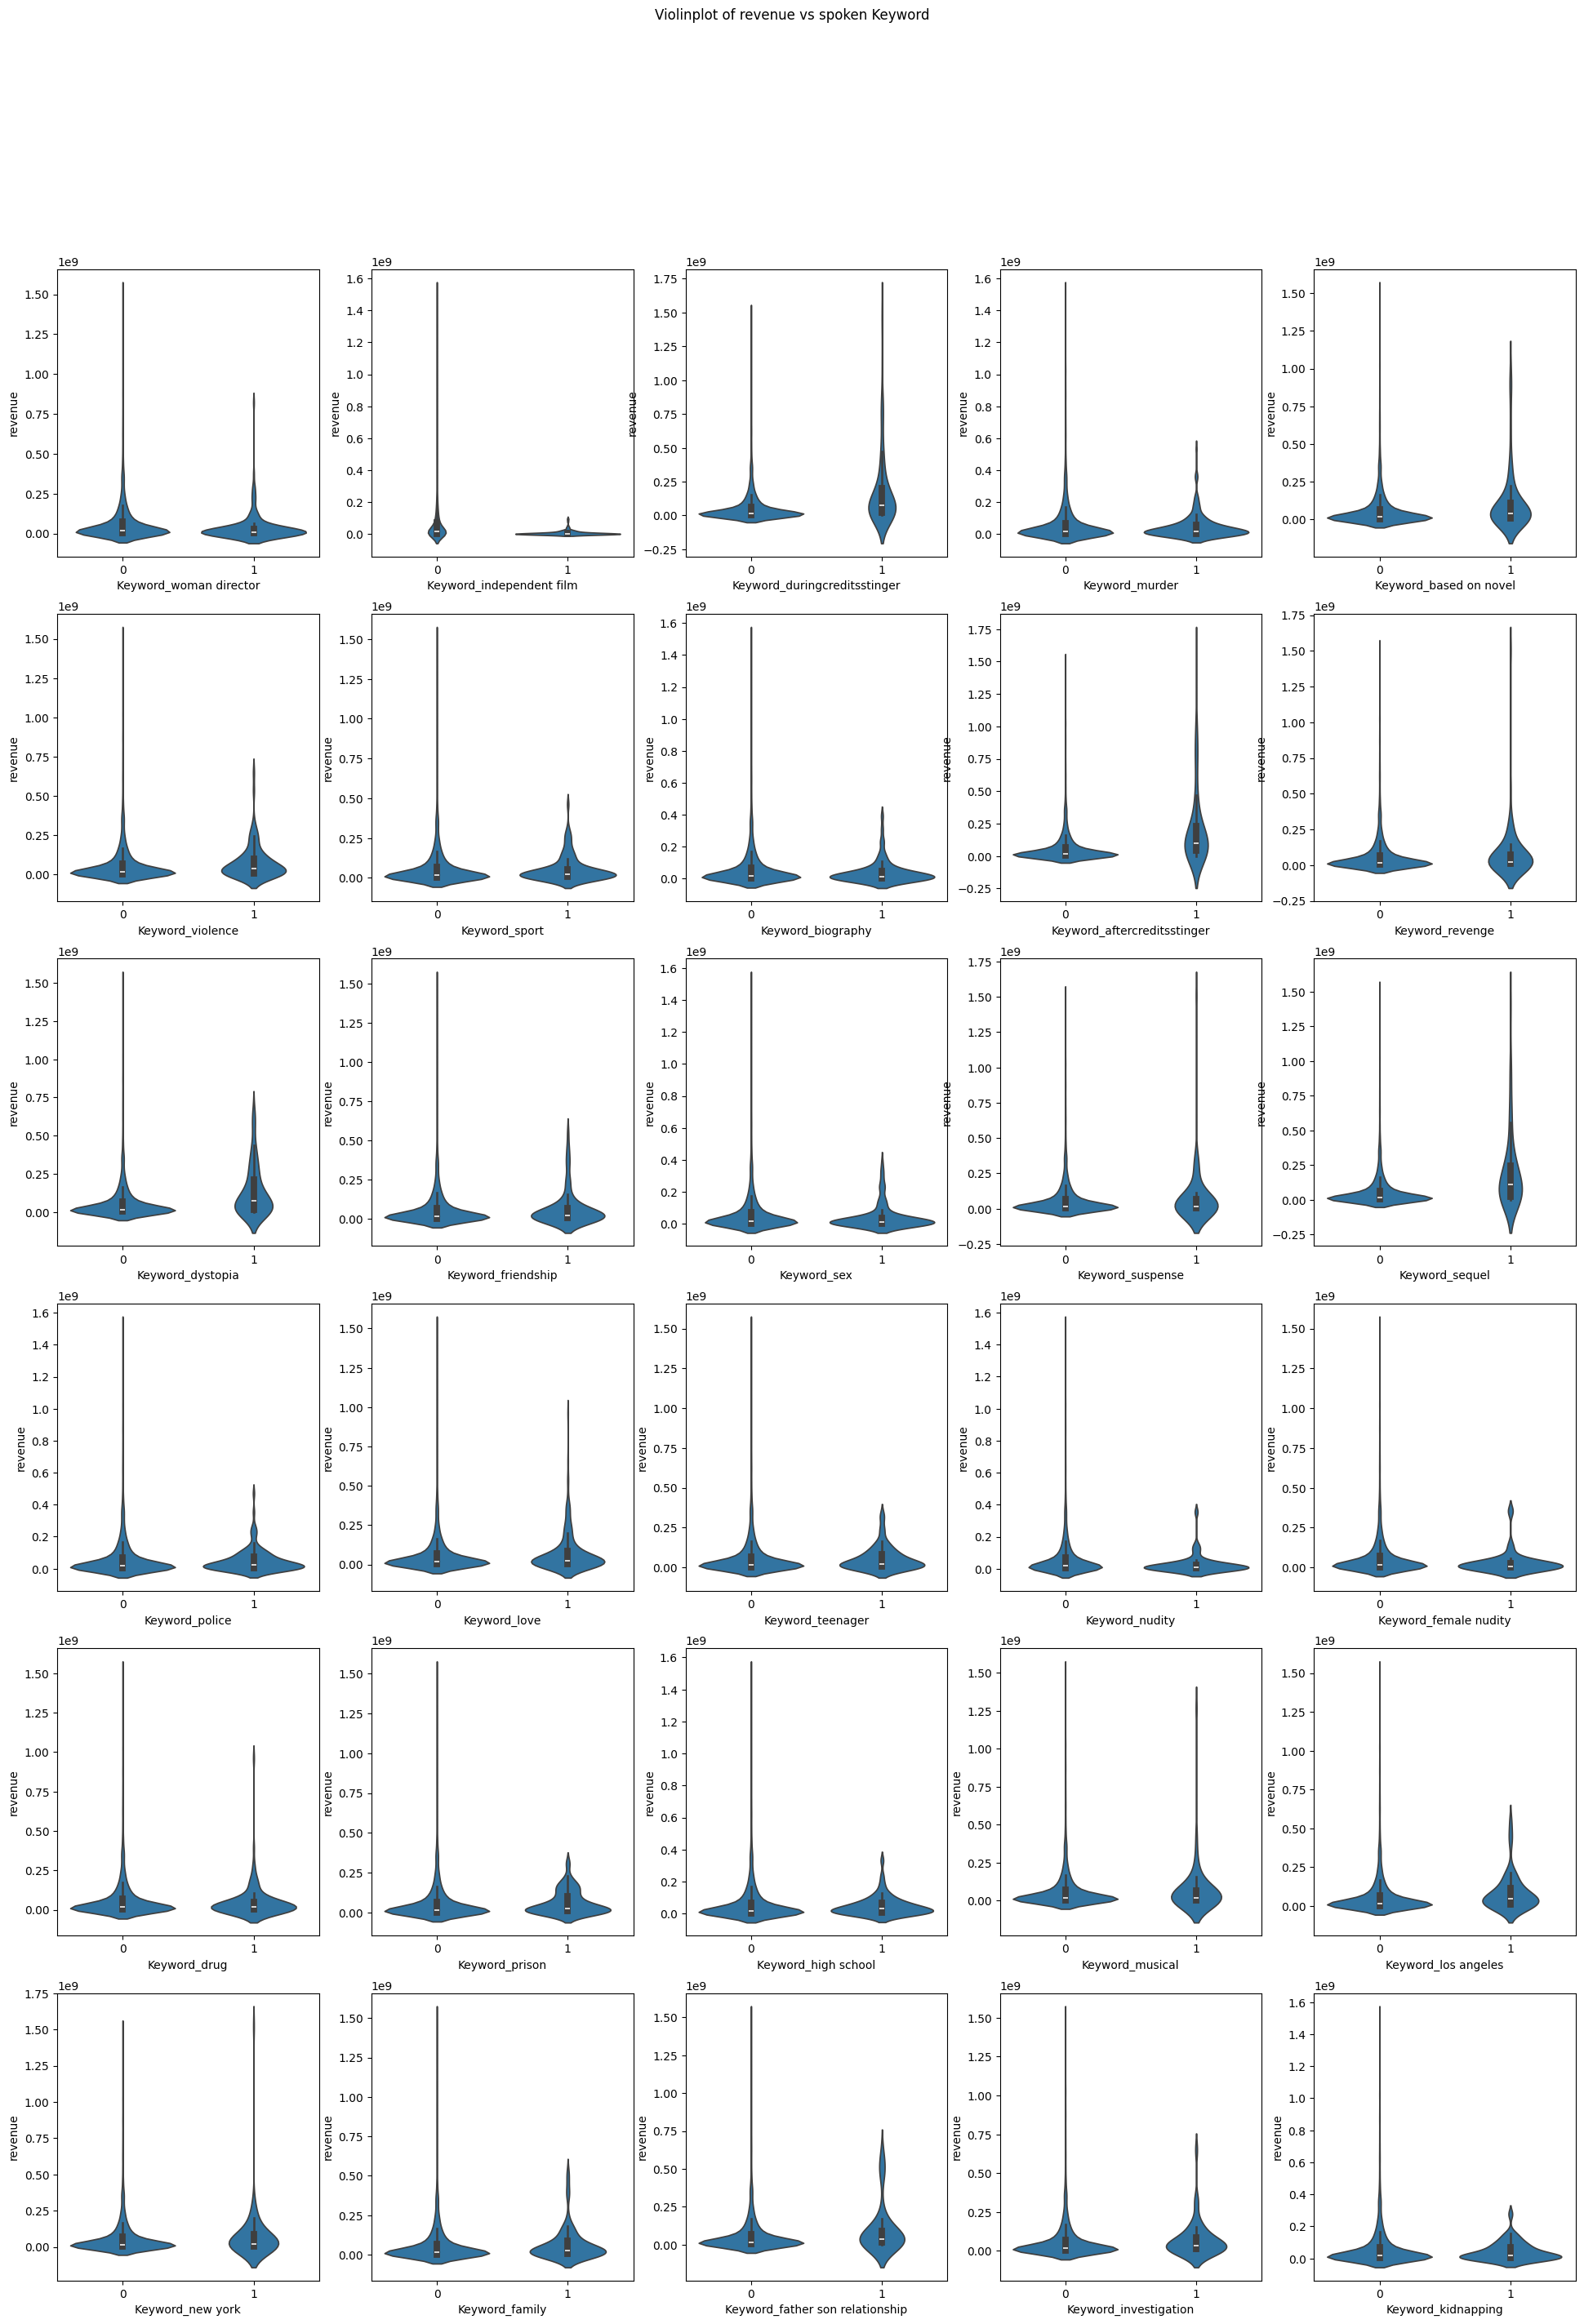

In [374]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs spoken Keyword')
for i, e in enumerate([col for col in data.columns if 'Keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

### Колонка cast

Изучаем содержимое данных, смотрим на популярных актёров

In [375]:
data['cast'] = data['cast'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["cast"][i]}')

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [376]:
info_cast = get_info_table_json(data['cast'], 'id')
info_cast

cast_id                            character                 credit_id  \
599        2.0                         Doyle Gipson  52fe42fbc3a36847f80317b1   
8016       1.0                        Dwight Hansen  52fe4492c3a36847f809dcd1   
758        3.0                           Billy Ford  52fe4469c3a36847f80949bd   
2213       1.0                         Joshep Blake  52fe438cc3a36847f805cb53   
2615       1.0                                voice  52fe44d99251416c9101eed7   
...        ...                                  ...                       ...   
25789     10.0                Captain Perry Vickers  52fe4668c3a36847f80fd535   
25790     11.0                Sir Charles Macefield  52fe4668c3a36847f80fd539   
25795     27.0  Major Jowett (as G. P. Huntley Jr.)  52fe4668c3a36847f80fd575   
25796     17.0                  Count Igor Volonoff  52fe4668c3a36847f80fd54d   
61831     79.0                     Helicopter Pilot  57bde91fc3a36818c5001823   

       gender         id               name  order  \
599       2.0     2231.0  Samuel L. Jackson    1.0   
8016      2.0      380.0     Robert De Niro    0.0   
758       2.0      192.0     Morgan Freeman    2.0   
2213      2.0       62.0       Bruce Willis    0.0   
2615      2.0     3896.0        Liam Neeson    0.0   
...       ...        ...                ...    ...   
25789     2.0     8726.0     Patric Knowles    2.0   
25790     2.0    81934.0   Henry Stephenson    3.0   
25795     0.0   120821.0       G.P. Huntley    8.0   
25796     2.0    88672.0      Robert Barrat    9.0   
61831     2.0  1669797.0    Cherokee Walker   28.0   

                           profile_path  duplicate_count  
599    /AvCReLikjzYEf9XjTQxbv3JWgKT.jpg               30  
8016   /lvTSwUcvJRLAJ2FB5qFaukel516.jpg               30  
758    /oGJQhOpT8S1M56tvSsbEBePV5O1.jpg               27  
2213   /2B7RySy2WMVJKKEFN2XA3IFb8w0.jpg               25  
2615   /9mdAohLsDu36WaXV2N3SQ388bvz.jpg               25  
...                                 ...              ...  
25789  /nnfyDm40s2buFc5tEZe25Ded2Ua.jpg                1  
25790  /wZgaeGbsFPCWfbnQJemCcpPCNAo.jpg                1  
25795  /heZ2zGeeh8EgH4MG5I6jLqGTvSg.jpg                1  
25796  /hP59p1hbbBizWea0ayGoCXjY8r5.jpg                1  
61831  /dhKQTMgLF9d585kQlA0q08tIIot.jpg                1  

[24664 rows x 9 columns]

Актёров очень много, сократим их количество до 30, оставив самых активных

In [377]:
data['cast_name'] = get_items_from_json('name', 'cast')
new_columns = pd.DataFrame(index=data.index)
for g in info_cast['name'][:30]:
    new_columns['cast_name_' + g] = data['cast_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов фильма от актёров

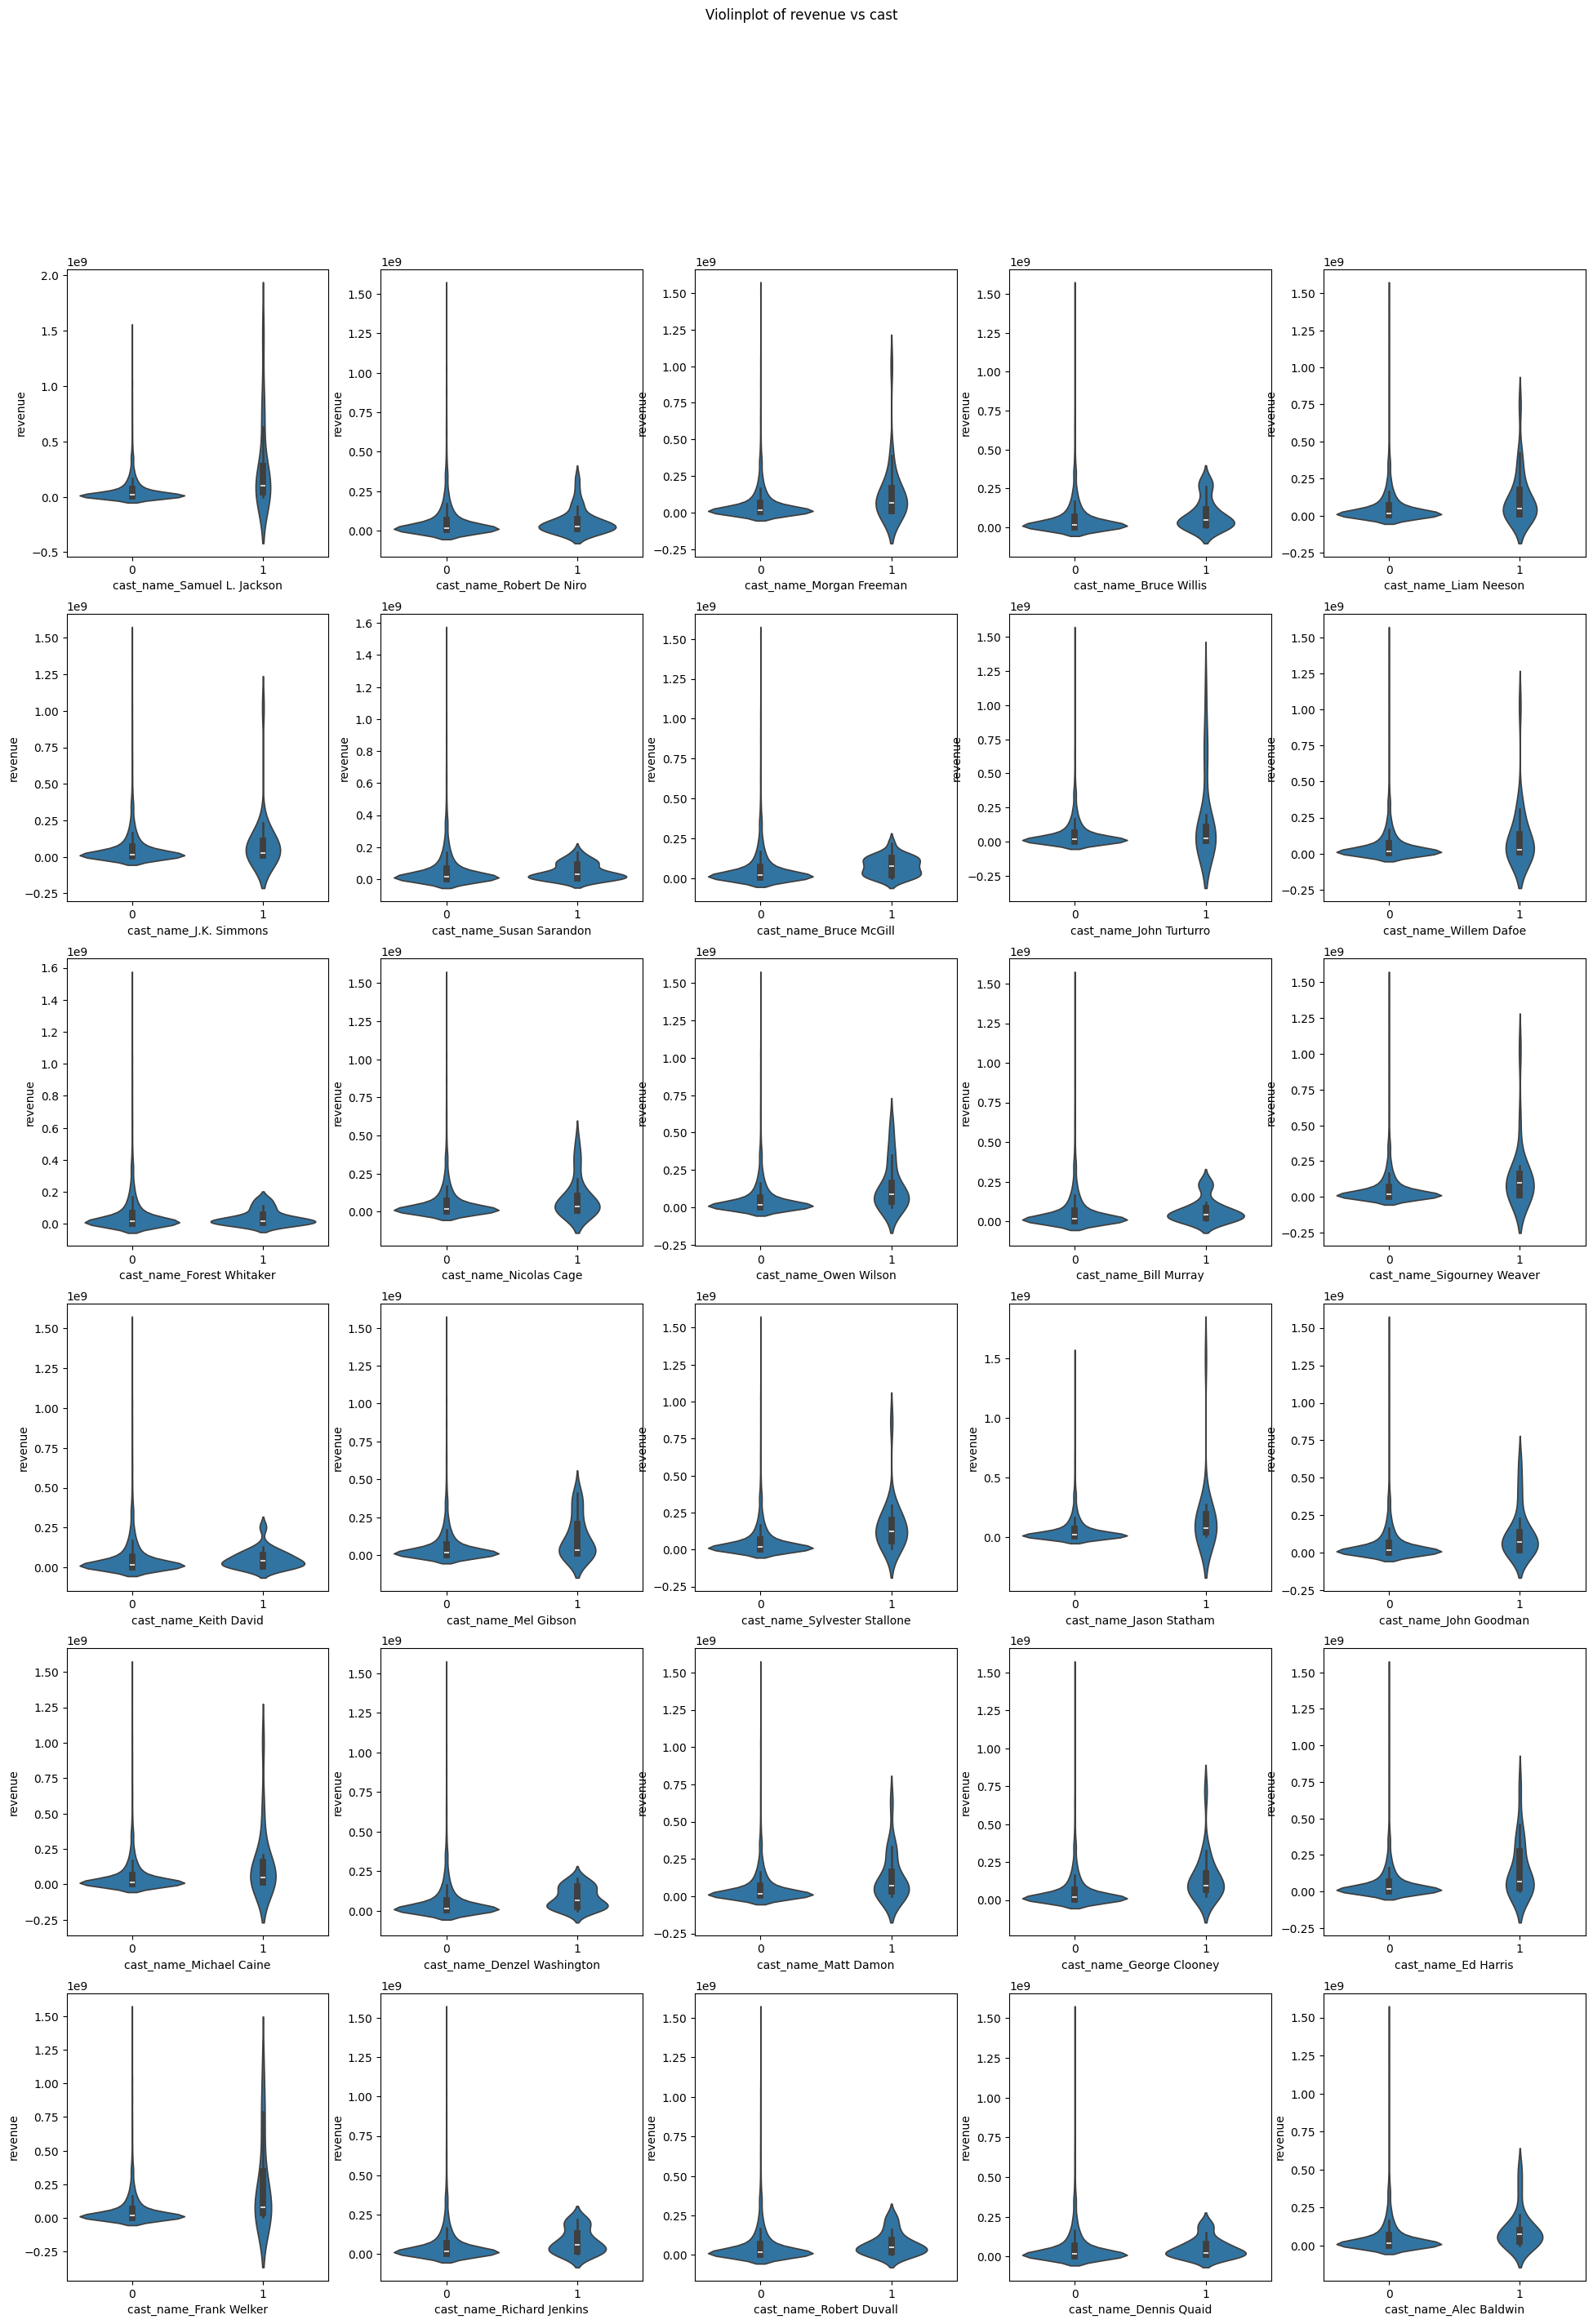

In [378]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in data.columns if 'cast_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

### Колонка crew

Поступим здесь точно так же, как и с актёрами

In [379]:
data['crew'] = data['crew'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x) )
for i in range (5):
  print(f'{i} {data["crew"][i]}')

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [380]:
info_crew = get_info_table_json(data['crew'], 'id')
info_crew

credit_id  department  gender       id  \
4510   5555cccac3a368777400233e  Production     1.0   2952.0   
2453   56a517709251410c080054d2        Crew     2.0   2294.0   
2145   52fe435fc3a36847f804f747  Production     1.0   3965.0   
1191   52fe446ac3a36847f8094a11       Sound     2.0   1213.0   
7100   52fe4957c3a368484e1269f5  Production     1.0   5914.0   
...                         ...         ...     ...      ...   
31994  52fe433ac3a36847f8043ed3   Directing     2.0  21931.0   
31970  553f242b92514138a900bcdd     Writing     1.0  32501.0   
31856  52fe44b2c3a368484e031a57     Writing     2.0   9051.0   
31847  52fe447fc3a36847f8099a59   Directing     0.0  43141.0   
72971  52fe443a9251416c7502d597  Production     1.0  16935.0   

                           job                 name  \
4510                   Casting          Avy Kaufman   
2453                    Thanks     Robert Rodriguez   
2145                   Casting       Deborah Aquila   
1191   Original Music Composer  James Newton Howard   
7100                   Casting         Mary Vernieu   
...                        ...                  ...   
31994                 Director          Chris Nahon   
31970                   Writer       Pascale Ferran   
31856                   Author        L. Frank Baum   
31847                 Director          Pete Travis   
72971                 Producer          Geena Davis   

                           profile_path  duplicate_count  
4510   /yQPGktsmkKkhkOQAUlmYlxHJOiJ.jpg               50  
2453   /bPqRdLWWwpOT8sBdj9PWOzNgwou.jpg               44  
2145   /7OBiqW30sXcW4f2xMds53L4JBN5.jpg               40  
1191   /5UTEMYS7rydwe7ooOmj2dLRFuu2.jpg               39  
7100   /rluDG0SLCvh3rVkMMp44C31iHIN.jpg               38  
...                                 ...              ...  
31994  /5ei81yfFCVBPdDw8AntZPM1U0Jy.jpg                1  
31970  /ziRiEtYYtOGb68b9bpzSKi14Wmt.jpg                1  
31856  /71j62WM8z6XN1DXnSv4AWjMUxJS.jpg                1  
31847  /xHxcow0RqzkTM2vwgfnpOT2FoSe.jpg                1  
72971  /6b8cRJOItz7yNpYuLCPkl5kv4m2.jpg                1  

[4190 rows x 8 columns]

In [381]:
data['crew_name'] = get_items_from_json('name', 'crew')
new_columns = pd.DataFrame(index=data.index)
for g in info_crew['name'][:30]:
    new_columns['crew_name_' + g] = data['crew_name'].apply(lambda x: 1 if g in x else 0)
data = pd.concat([data, new_columns], axis=1)

#### График зависимости сборов фильма от участника съёмочной группы

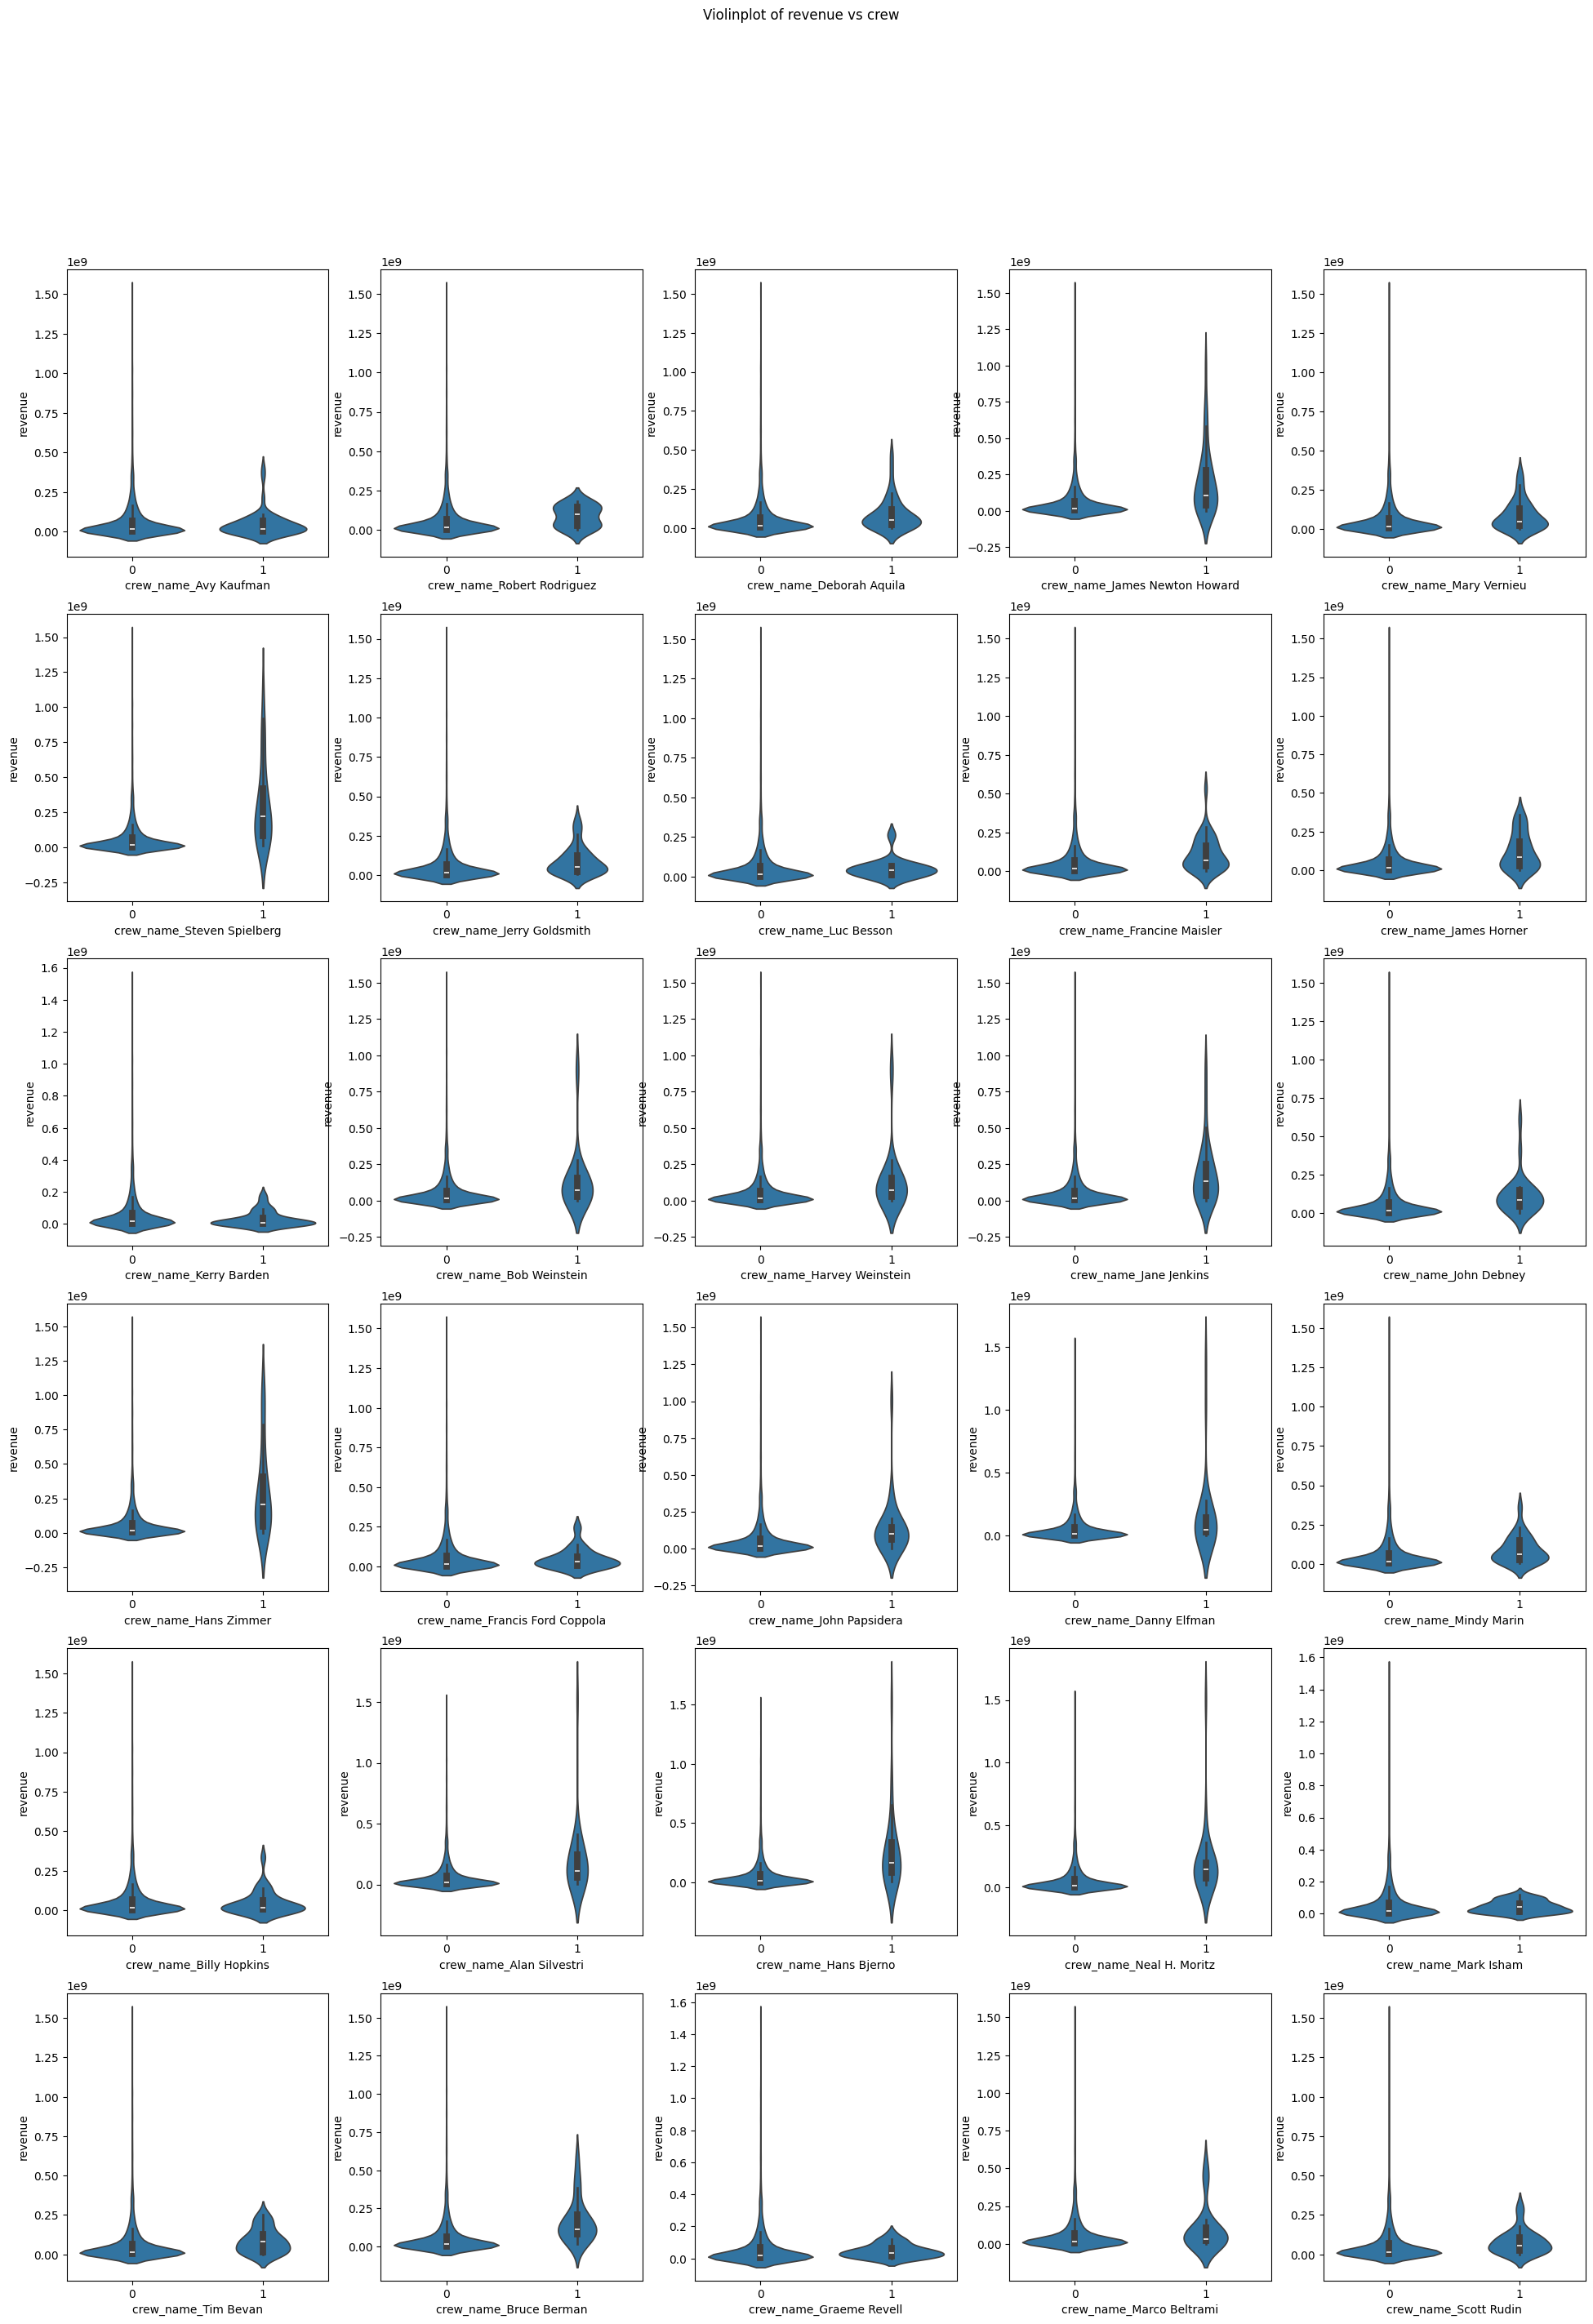

In [382]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs crew')
for i, e in enumerate([col for col in data.columns if 'crew_name_' in col]):
    sns.violinplot(x=e, y='revenue', data=data, ax=axes[i // 5][i % 5]);

## Target

### Распределение сборов фильма

Text(0.5, 1.0, 'revenue')

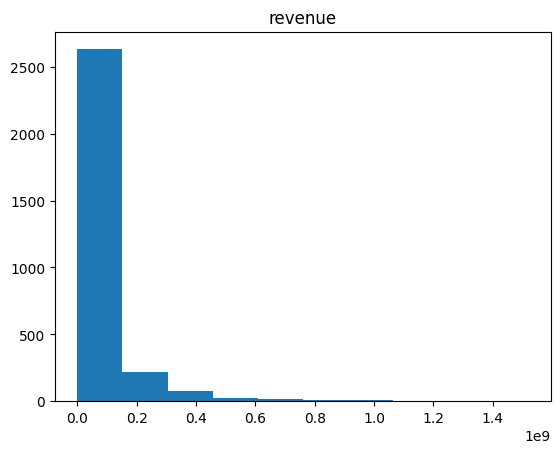

In [383]:
plt.hist(data['revenue'])
plt.title('revenue')

Данные сильно смещены к нулю, отцентруем данные для их нормализации

In [384]:
def get_centered(x):
    return (x - x.mean()) / x.std()

Text(0.5, 1.0, 'Centered revenue')

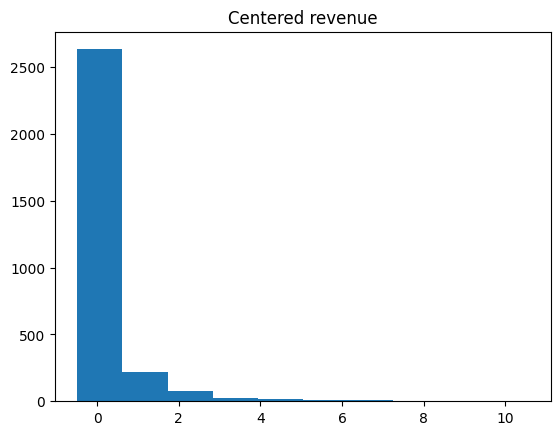

In [385]:
norm = get_centered(data['revenue'])
plt.hist(norm)
plt.title('Centered revenue')

Попробуем применить функцию log1p

Text(0.5, 1.0, 'log of revenue')

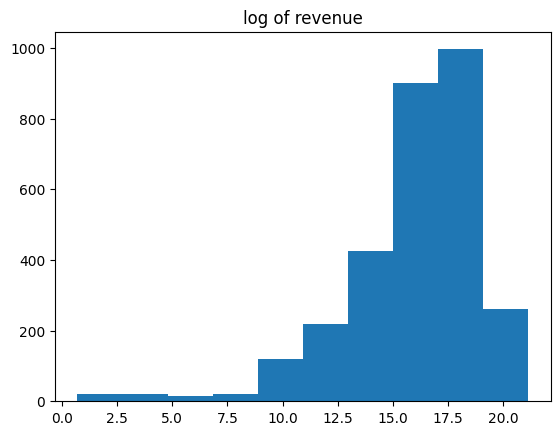

In [405]:
norm_log = np.log1p(data['revenue'])
plt.hist(norm_log)
plt.title('log of revenue')

Теперь выглядит хорошо, будем это использовать

### Бюджет

То же самое сделаем с бюджетом

Text(0.5, 1.0, 'Distribution of centered budget')

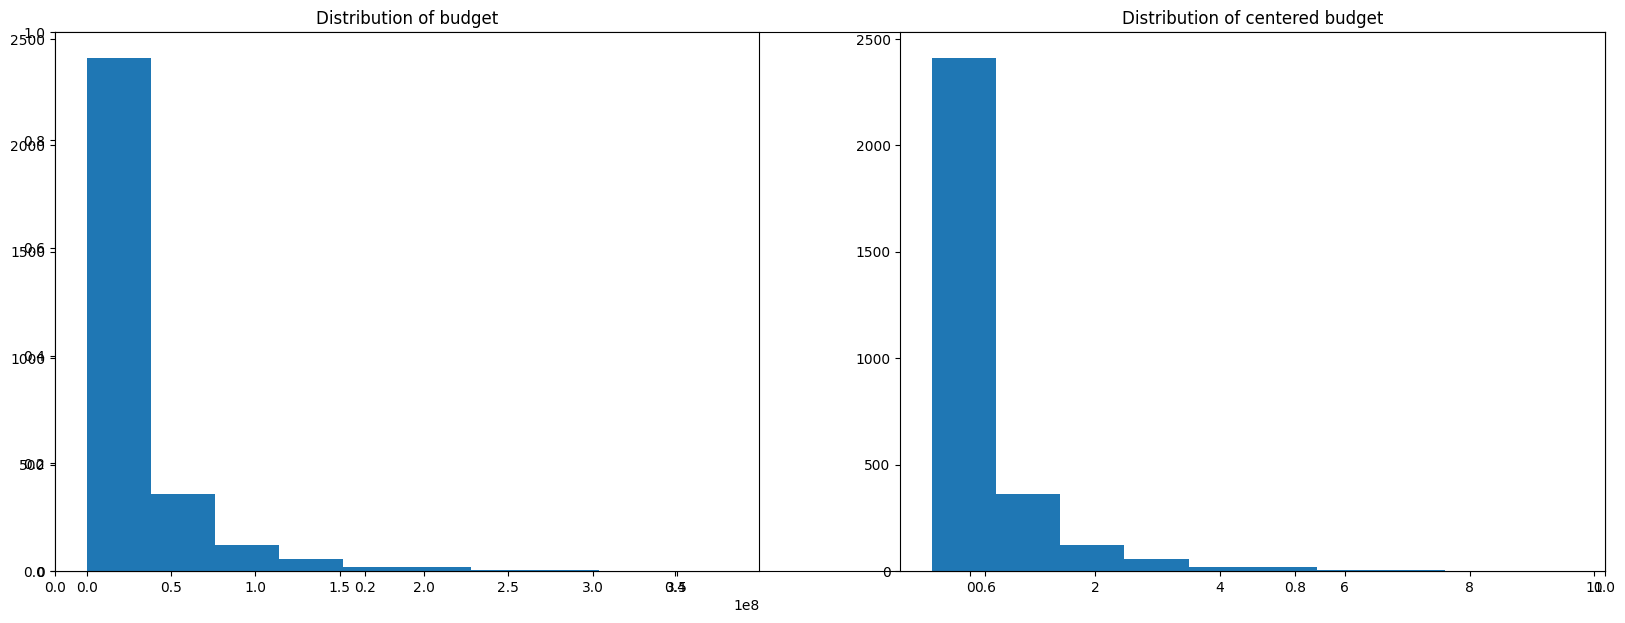

In [386]:
data['centered_budget'] = (data['budget'] - data['budget'].mean()) / data['budget'].std()
plt.subplots(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.hist(data['budget'])
plt.title('Distribution of budget')
plt.subplot(1, 2, 2)
plt.hist(data['centered_budget'])
plt.title('Distribution of centered budget')

Столбик у нуля это часть строк, где бюджет изначально был нулевым

## Теперь рассмотрим колонки с текстом


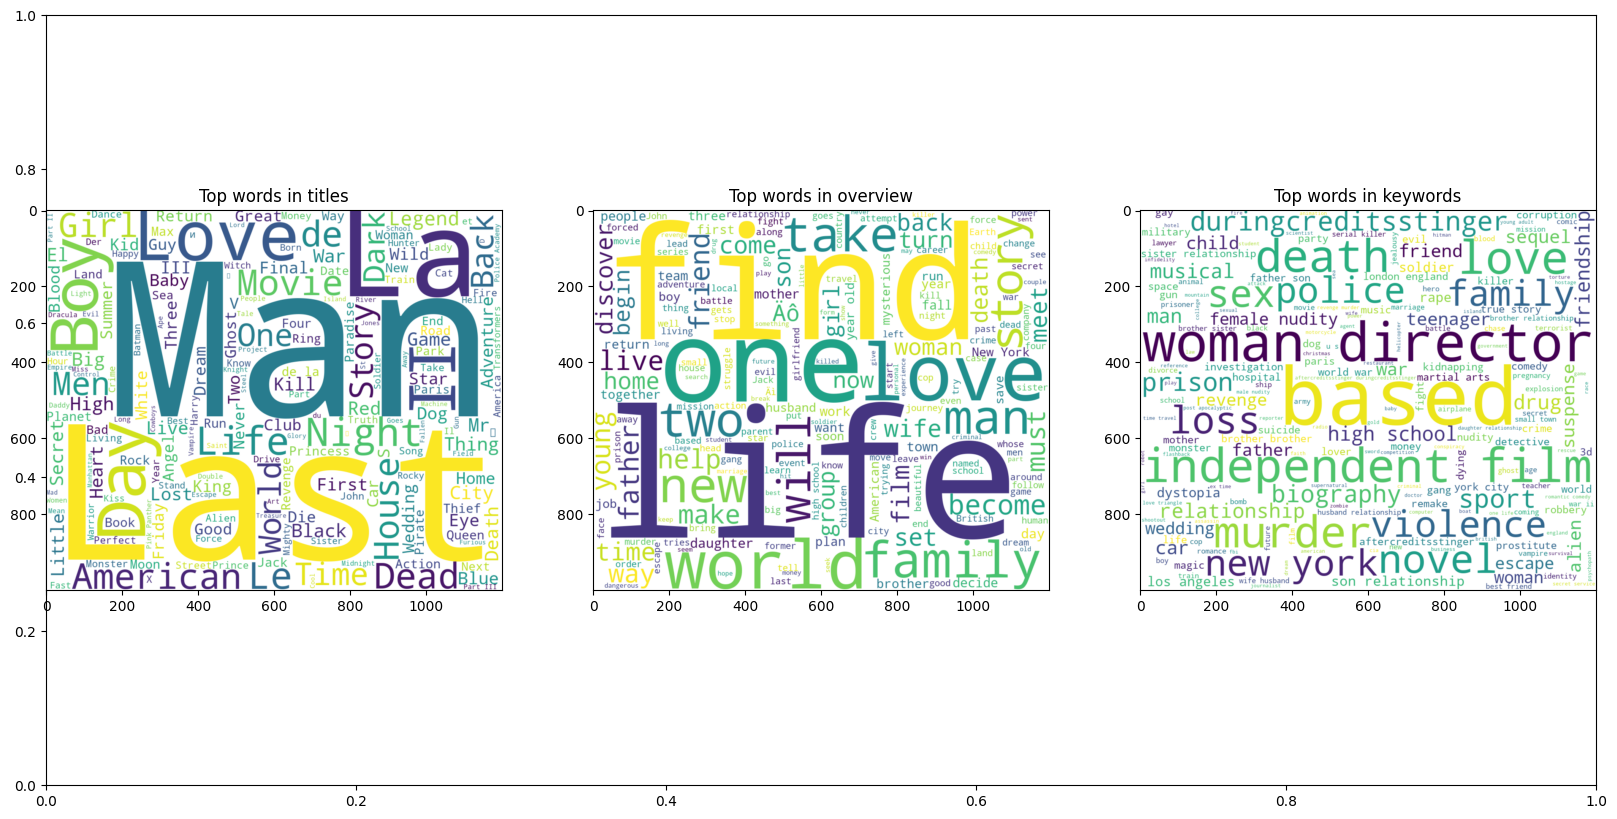

In [387]:
text_title = ' '.join(data['original_title'].values)
wordcloud_title = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_title)
text_overview = ' '.join(data['overview'].fillna('').values)
wordcloud_overview = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_overview)
text_keywords = ' '.join(data['Keywords_name'].fillna('').values)
wordcloud_keywords = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_keywords)

plt.subplots(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Top words in titles')
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_overview, interpolation='bilinear')
plt.title('Top words in overview')
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_keywords, interpolation='bilinear')
plt.title('Top words in keywords')
plt.show()

Выглядит так, как будто бы нужно рассматривать все эти колонки, потому что разные популярные слова

#### TFIDF матрица для названий фильмов
Получим TFIDM матрицу оценки важности слов в заголовках (названиях) фильмов и добавим её в исходную таблицу

In [388]:
data['title'] = data['title'].fillna('')
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            stop_words='english',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=15)
X = vectorizer.fit_transform(data['title'])
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix = pd.DataFrame(data=X.toarray(), columns=feature_names+'_title')
data = pd.concat([data, tfidf_matrix], axis=1)
tfidf_matrix

2_title  3_title  american_title  big_title  city_title  day_title  \
0         1.0      0.0             0.0        0.0         0.0        0.0   
1         1.0      0.0             0.0        0.0         0.0        0.0   
2         0.0      0.0             0.0        0.0         0.0        0.0   
3         0.0      0.0             0.0        0.0         0.0        0.0   
4         0.0      0.0             0.0        0.0         0.0        0.0   
...       ...      ...             ...        ...         ...        ...   
2995      0.0      0.0             0.0        0.0         0.0        0.0   
2996      0.0      0.0             0.0        0.0         0.0        0.0   
2997      0.0      0.0             0.0        0.0         0.0        0.0   
2998      0.0      0.0             0.0        0.0         0.0        0.0   
2999      0.0      0.0             0.0        0.0         0.0        0.0   

      dead_title  house_title  ii_title  life_title  love_title  man_title  \
0            0.0          0.0       0.0         0.0         0.0        0.0   
1            0.0          0.0       0.0         0.0         0.0        0.0   
2            0.0          0.0       0.0         0.0         0.0        0.0   
3            0.0          0.0       0.0         0.0         0.0        0.0   
4            0.0          0.0       0.0         0.0         0.0        0.0   
...          ...          ...       ...         ...         ...        ...   
2995         0.0          0.0       0.0         0.0         0.0        0.0   
2996         0.0          0.0       0.0         0.0         0.0        0.0   
2997         0.0          0.0       0.0         0.0         0.0        0.0   
2998         0.0          0.0       0.0         0.0         0.0        0.0   
2999         0.0          0.0       0.0         0.0         0.0        0.0   

      movie_title  night_title  red_title  s_title  story_title  
0             0.0          0.0        0.0      0.0          0.0  
1             0.0          0.0        0.0      0.0          0.0  
2             0.0          0.0        0.0      0.0          0.0  
3             0.0          0.0        0.0      0.0          0.0  
4             0.0          0.0        0.0      0.0          0.0  
...           ...          ...        ...      ...          ...  
2995          0.0          0.0        0.0      0.0          0.0  
2996          0.0          0.0        0.0      0.0          0.0  
2997          0.0          0.0        0.0      0.0          0.0  
2998          0.0          0.0        0.0      0.0          0.0  
2999          0.0          0.0        0.0      0.0          0.0  

[3000 rows x 17 columns]

#### TFIDF для описаний к фильмам

In [389]:
data['overview'] = data['overview'].fillna('')
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            stop_words='english',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=200)
X = vectorizer.fit_transform(data['overview'])
feature_names = vectorizer.get_feature_names_out()

tfidf_matrix = pd.DataFrame(data=X.toarray(), columns=feature_names+'overview')
data = pd.concat([data, tfidf_matrix], axis=1)

tfidf_matrix

familyoverview  fatheroverview  findsoverview  lifeoverview  \
0                0.0        0.706173       0.000000      0.000000   
1                0.0        0.000000       0.000000      1.000000   
2                0.0        0.000000       0.000000      0.000000   
3                0.0        0.000000       0.000000      1.000000   
4                0.0        0.000000       0.736745      0.000000   
...              ...             ...            ...           ...   
2995             0.0        0.000000       0.000000      0.000000   
2996             0.0        0.000000       0.000000      0.000000   
2997             0.0        0.000000       0.000000      1.000000   
2998             0.0        0.000000       0.000000      0.701014   
2999             0.0        0.000000       0.000000      0.523415   

      loveoverview  manoverview  newoverview  soverview  storyoverview  \
0              0.0     0.000000          0.0   0.000000       0.000000   
1              0.0     0.000000          0.0   0.000000       0.000000   
2              0.0     0.000000          0.0   0.000000       0.000000   
3              0.0     0.000000          0.0   0.000000       0.000000   
4              0.0     0.000000          0.0   0.000000       0.676171   
...            ...          ...          ...        ...            ...   
2995           0.0     0.000000          0.0   1.000000       0.000000   
2996           0.0     0.000000          0.0   0.000000       0.000000   
2997           0.0     0.000000          0.0   0.000000       0.000000   
2998           0.0     0.000000          0.0   0.516995       0.000000   
2999           0.0     0.617935          0.0   0.000000       0.000000   

      timeoverview  worldoverview  youngoverview  
0         0.708039       0.000000        0.00000  
1         0.000000       0.000000        0.00000  
2         0.000000       0.000000        1.00000  
3         0.000000       0.000000        0.00000  
4         0.000000       0.000000        0.00000  
...            ...            ...            ...  
2995      0.000000       0.000000        0.00000  
2996      0.000000       0.000000        0.00000  
2997      0.000000       0.000000        0.00000  
2998      0.000000       0.491217        0.00000  
2999      0.000000       0.000000        0.58668  

[3000 rows x 12 columns]

## Разделим дату на год и месяц релиза

In [390]:
data['release_date'] = pd.to_datetime(data['release_date'])
data['year'] = data['release_date'].dropna()
data['month'] = data['release_date'].dropna()
data['year'] = data['release_date'].dt.year.astype('Int64')
data.loc[data['year'] > 2023, 'year'] -= 100
data['month'] = data['release_date'].dt.month.astype('Int64')

## Категориальные переменные

Кодируем оставшиеся категориальные переменные с помощью LabelEncoder

In [391]:
for col in ['original_language', 'collection_name']:
    le = LabelEncoder()
    le.fit(list(data[col].fillna('')))
    data[col] = le.transform(data[col].fillna('').astype(str))

## Почистим таблицу

In [392]:
pd.set_option('display.max_columns', None)
data.head(2)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   

                                              genres homepage    imdb_id  \
0                     [{'id': 35, 'name': 'Comedy'}]      NaN  tt2637294   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0368933   

   original_language                            original_title  \
0                  7                    Hot Tub Time Machine 2   
1                  7  The Princess Diaries 2: Royal Engagement   

                                            overview  popularity  \
0  When Lou, who has become the "father of the In...    6.575393   
1  Mia Thermopolis is now a college graduate and ...    8.248895   

                        poster_path  \
0  /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg   
1  /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg   

                                production_companies  \
0  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1        [{'name': 'Walt Disney Pictures', 'id': 2}]   

                                production_countries release_date  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...   2015-02-20     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...   2004-08-06    113.0   

                           spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   

                                                crew   revenue  \
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651   
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435   

   collection_name  has_collection                    genres_names  \
0              152               1                          Comedy   
1              366               1  Comedy, Drama, Family, Romance   

   genre_Drama  genre_Comedy  genre_Thriller  genre_Action  genre_Romance  \
0            0             1               0             0              0   
1            1             1               0             0              1   

   genre_Crime  genre_Adventure  genre_Horror  genre_Science Fiction  \
0            0                0             0                      0   
1            0                0             0                      0   

   genre_Family  genre_Fantasy  genre_Mystery  genre_Animation  genre_History  \
0             0              0              0                0              0   
1             1              0              0                0              0   

   genre_War  genre_Music  genre_Documentary  genre_Western  genre_Foreign  \
0          0            0                  0              0              0   
1          0            0                  0              0              0   

   genre_TV Movie                         production_companies_names  \
0               0  Paramount Pictures, United Artists, Metro-Gold...   
1               0                               Walt Disney Pictures   

   production_company_Warner Bros.  production_company_Universal Pictures  \
0                                0                                      0   
1                                0                                      0   

   production_company_Paramou

In [393]:
data = data.drop(columns = ['id', 'belongs_to_collection', 'genres', 'homepage', 'imdb_id', 'original_title',
                            'overview', 'poster_path', 'production_companies', 'production_countries',
                            'production_countries_id', 'release_date', 'spoken_languages', 'status', 'tagline', 'title', 'budget',
                            'Keywords', 'cast', 'crew', 'genres_names', 'production_companies_names', 'Keywords_name', 'cast_name', 'crew_name', 'spoken_languages_id'], axis = 1)
data

original_language  popularity  runtime    revenue  collection_name  \
0                     7    6.575393     93.0   12314651              152   
1                     7    8.248895    113.0   95149435              366   
2                     7   64.299990    105.0   13092000                1   
3                    13    3.174936    122.0   16000000                1   
4                    18    1.148070    118.0    3923970                1   
...                 ...         ...      ...        ...              ...   
2995                  7    9.853270    102.0    1596687                1   
2996                 29    3.727996    102.0     180590                1   
2997                  7   14.482345    120.0   89456761                1   
2998                  7   15.725542     90.0  171963386                1   
2999                  7   10.512109    106.0   82087155                1   

      has_collection  genre_Drama  genre_Comedy  genre_Thriller  genre_Action  \
0                  1            0             1               0             0   
1                  1            1             1               0             0   
2                  0            1             0               0             0   
3                  0            1             0               1             0   
4                  0            0             0               1             1   
...              ...          ...           ...             ...           ...   
2995               0            0             1               0             0   
2996               0            1             0               0             0   
2997               0            0             0               1             1   
2998               0            0             1               0             0   
2999               0            0             0               1             1   

      genre_Romance  genre_Crime  genre_Adventure  genre_Horror  \
0                 0            0                0             0   
1                 1            0                0             0   
2                 0            0                0             0   
3                 0            0                0             0   
4                 0            0                0             0   
...             ...          ...              ...           ...   
2995              1            0                0             0   
2996              0            0                0             0   
2997              0            1                0             0   
2998              1            0                0             0   
2999              0            0                0             0   

      genre_Science Fiction  genre_Family  genre_Fantasy  genre_Mystery  \
0                         0             0              0              0   
1                         0             1              0              0   
2                         0             0              0              0   
3                         0             0              0              0   
4                         0             0              0              0   
...                     ...           ...            ...            ...   
2995                      0             0              0              0   
2996                      0             0              0              0   
2997                      0             0              0              1   
2998                      0             0              0              0   
2999                      0             0              0              1   

      genre_Animation  genre_History  genre_War  genre_Music  \
0                   0              0          0            0   
1                   0              0          0            0   
2                   0              0          0            0   
3                   0              0          0            0   
4                   0              0          0            0   
...               ...         

## Обучение модели

### 1. Пробуем отцентровать таргет

Разделяем данные на тестовую и обучающую выборки

In [394]:
data = data.dropna()
X = data.drop(['revenue'], axis=1)
y = data['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)

Центруем target

In [395]:
scaler = StandardScaler()
y_train_centered = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

Обучаем модели и смотрим метрики MSE для предсказаний

In [396]:
# Градиентный бустинг
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train_centered)
gb_predictions = gb_model.predict(X_test)
gb_pred_non_centered = scaler.inverse_transform(np.array(gb_predictions).reshape(-1, 1))
gb_mse = mean_squared_error(y_test, gb_pred_non_centered, squared=False)
print(f'Gradient Boosting RMSE: {gb_mse}')

# Случайный лес
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train_centered)
rf_predictions = rf_model.predict(X_test)
rf_predictions_non_centered = scaler.inverse_transform(np.array(rf_predictions).reshape(-1, 1))
rf_mse = mean_squared_error(y_test, rf_predictions_non_centered, squared=False)
print(f'Random Forest RMSE: {rf_mse}')

Gradient Boosting RMSE: 82996871.83136335
Random Forest RMSE: 75314043.4992797


Эти цифры показались нам страшными, но все таки мы предсказываем сборы фильмов, а эти числа очень большие, поэтому мы обратились к другим метрикам оценки качества моделей

#### Теория R^2

$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$

Сумма квадратов остатков (SSE) измеряет сумму квадратов разностей между фактическими значениями и предсказанными значениями.

Сумма квадратов отклонений от среднего (SST) измеряет сумму квадратов разностей между фактическими значениями и средним значением зависимой переменной.

In [397]:
gb_r2 = r2_score(y_test, gb_pred_non_centered)
print(f'Gradient Boosting R-squared: {gb_r2}')

rf_r2 = r2_score(y_test, rf_predictions_non_centered)
print(f'Random Forest R-squared: {rf_r2}')

Gradient Boosting R-squared: 0.58196193769815
Random Forest R-squared: 0.6557734947990999


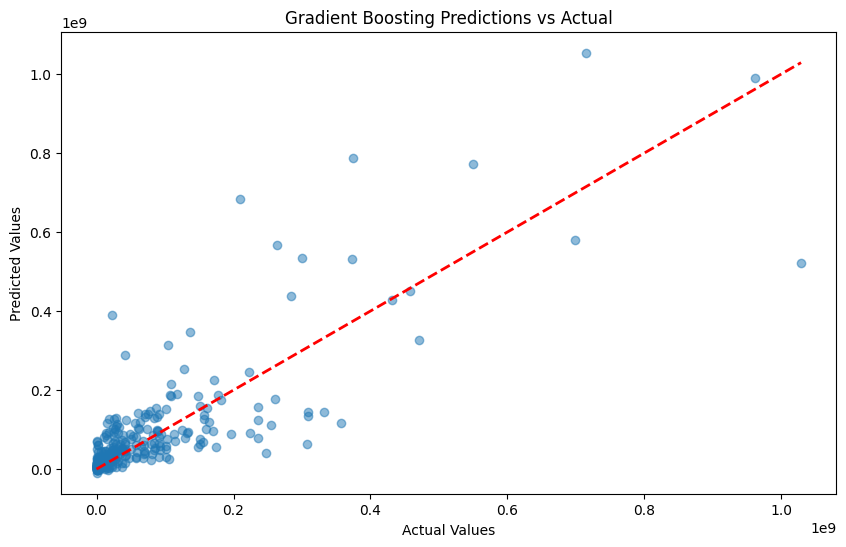

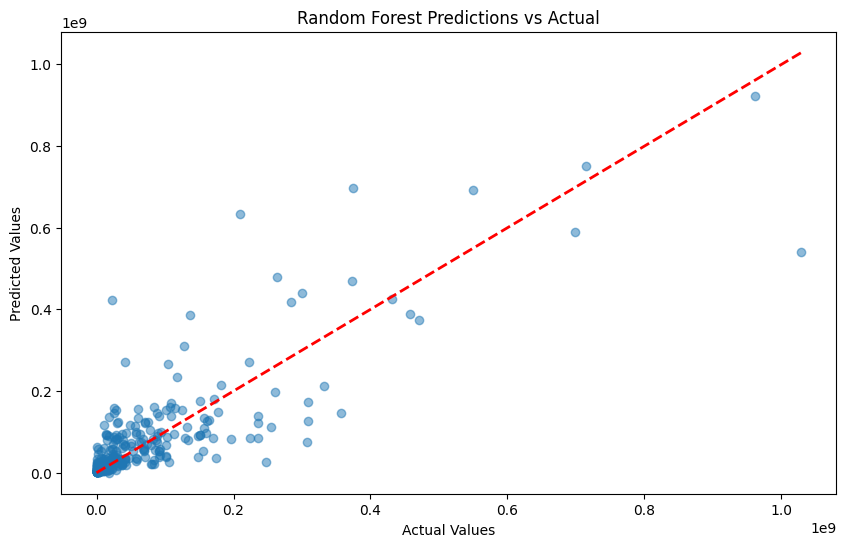

In [398]:
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red', linewidth=2)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

plot_predictions(y_test, gb_pred_non_centered, 'Gradient Boosting')
plot_predictions(y_test, rf_predictions_non_centered, 'Random Forest')

Как видим модель не очень то хорошо справляется с предсказанием, поэтому попробуем другой способ нормализации таргета

### 2. Используем log1p

Разделяем данные на тестовую и обучающую выборки

In [399]:
data = data.dropna()
X = data.drop(['revenue'], axis=1)
y = data['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)

Применяем функцию log(1+x) для таргета

In [400]:
y_train_log = np.log1p(y_train)

Обучаем модели и смотрим метрики MSE для предсказаний

In [401]:
# Градиентный бустинг
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train_log)
gb_predictions = gb_model.predict(X_test)
gb_pred_exp = np.expm1(gb_predictions)
gb_mse = mean_squared_error(y_test, gb_pred_exp, squared=False)
print(f'Gradient Boosting RMSE: {gb_mse}')

# Случайный лес
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train_log)
rf_predictions = rf_model.predict(X_test)
rf_predictions_exp = np.expm1(rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions_exp, squared=False)
print(f'Random Forest RMSE: {rf_mse}')

Gradient Boosting RMSE: 77008795.49338093
Random Forest RMSE: 74548835.4001433


In [402]:
gb_r2 = r2_score(y_test, gb_pred_exp)
print(f'Gradient Boosting R-squared: {gb_r2}')

rf_r2 = r2_score(y_test, rf_predictions_exp)
print(f'Random Forest R-squared: {rf_r2}')

Gradient Boosting R-squared: 0.6401072987514482
Random Forest R-squared: 0.6627328019918062


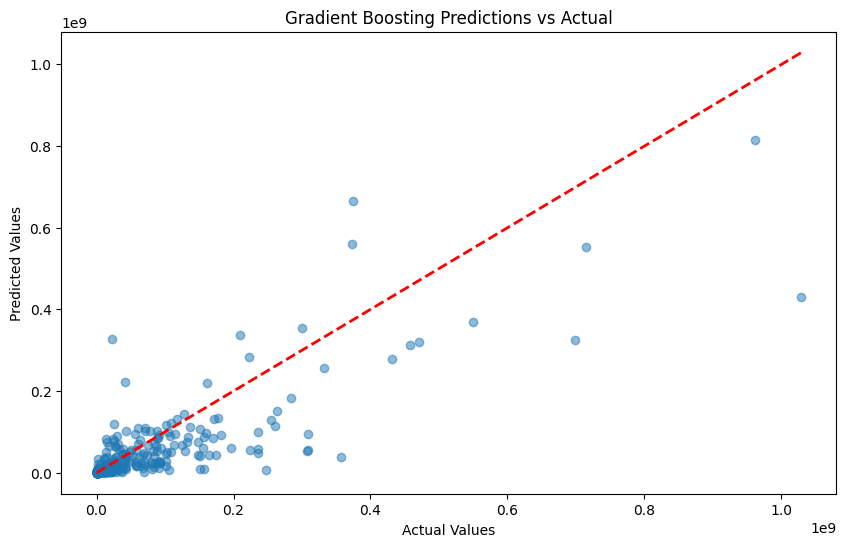

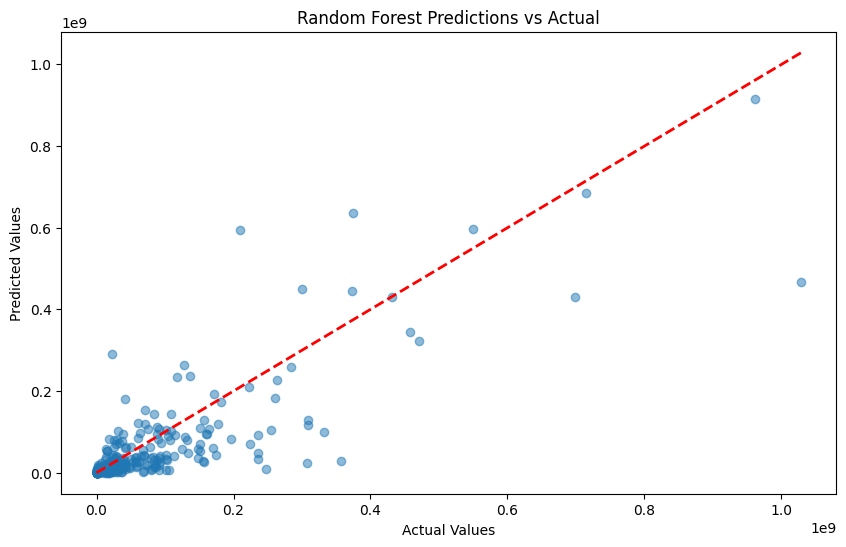

In [404]:
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red', linewidth=2)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

plot_predictions(y_test, gb_pred_exp, 'Gradient Boosting')
plot_predictions(y_test, rf_predictions_exp, 'Random Forest')